# This is the experiments draft for the same store solution.


It contains the experiments for the following steps:

1. Construct entity embeddings via NN for the categorical variables (such as Stores, weekdays etc)
2. Visualize the interpretability of entity embeddings and verified its validity with real life patterns
3. Tested the semi-supervised approach: not working well 
4. Compared with other trendy tabular models which are specifically Bayesian optimized. 


Please refer to the accompanied pdf for compiled results.



## Rossmann dataset

Rossmann's Kaggle competition was a business sales prediction competition for $35,000 dollars to the winners.

The premise is that we're given the sales data and information of their stores for the past few years. We need to make a model that can predict the number of sales that will be made in the future.

We can do this through a tabular regression model.

In [1]:
from pathlib import Path
from fastai2.tabular.all import *
from sklearn import manifold

In [341]:
# Setup ggplot graphing system. Done with matplotlib....

import rpy2
from rpy2.robjects import pandas2ri
pandas2ri.activate()
%load_ext rpy2.ipython


The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [3]:
DATA_PATH = Path("/home/jupyter/Tabular_project/data")

In [130]:
train = DATA_PATH/"train_clean"
test = DATA_PATH/'test_clean'

In [257]:
train_df = pd.read_pickle(train)

In [258]:
test_df = pd.read_pickle(test)
test_df.shape, train_df.shape

((41088, 92), (844338, 93))

With our time-series based approach, the feature engineering made a bunch of date-related categorical columns that we can utilize in our **embeddings**.

In [259]:
cat_vars = ['Store', 'DayOfWeek', 'Year', 'Month', 'Day', 'StateHoliday', 'CompetitionMonthsOpen',
    'Promo2Weeks', 'StoreType', 'Assortment', 'PromoInterval', 'CompetitionOpenSinceYear', 'Promo2SinceYear',
    'State', 'Week', 'Events', 'Promo_fw', 'Promo_bw', 'StateHoliday_fw', 'StateHoliday_bw',
    'SchoolHoliday_fw', 'SchoolHoliday_bw', 'Promo', 'SchoolHoliday']

cont_vars = ['CompetitionDistance', 'Max_TemperatureC', 'Mean_TemperatureC', 'Min_TemperatureC',
   'Max_Humidity', 'Mean_Humidity', 'Min_Humidity', 'Max_Wind_SpeedKm_h', 
   'Mean_Wind_SpeedKm_h', 'CloudCover', 'trend', 'trend_DE',
   'AfterStateHoliday', 'BeforeStateHoliday']
   
dep_var = 'Sales'

When doing Regression with these large numbers, we often use the **log** of these values for our `y`'s. Let's transform them real quick:

In [260]:
train_df[dep_var] = np.log(train_df[dep_var])

Now let's declare our `procs`

In [261]:
procs = [FillMissing, Normalize, Categorify]


And splits. Now we want to ensure that (since this is time series) our validation and test 

In [262]:
test_df['Date'].min(), test_df['Date'].max()

(Timestamp('2015-08-01 00:00:00'), Timestamp('2015-09-17 00:00:00'))

Let's find that particular index

In [263]:
idx = train_df['Date'][(train_df['Date'] == train_df['Date'][len(test_df)])].index.max()

In [264]:
idx

41395

So now our `splits` will be every index *after* the 41395'th item

In [265]:
splits = (L(range(idx, len(train_df))),L(range(idx)))

In [266]:
splits

((#802943) [41395,41396,41397,41398,41399,41400,41401,41402,41403,41404...],
 (#41395) [0,1,2,3,4,5,6,7,8,9...])

Let's make our `TabularPandas`! Since we have a large `DataFrame`, we can enable `inplace` to `True` and `reduce_memory` to `True` to save on some storage space (**Note**: `reduce_memory` is by default `True`). To use `inplace`, we need to set `chained_assignment` to `None` in `pandas`

In [267]:
pd.options.mode.chained_assignment=None

In [268]:
to = TabularPandas(train_df, procs, cat_vars, cont_vars, dep_var, RegressionBlock(), splits=splits, 
                   inplace=True, reduce_memory=True)


And now let's build our `dataloaders`!

In [140]:
dls = to.dataloaders(bs=512)

In [141]:
dls.show_batch()

,Store,DayOfWeek,Year,Month,Day,StateHoliday,CompetitionMonthsOpen,Promo2Weeks,StoreType,Assortment,PromoInterval,CompetitionOpenSinceYear,Promo2SinceYear,State,Week,Events,Promo_fw,Promo_bw,StateHoliday_fw,StateHoliday_bw,SchoolHoliday_fw,SchoolHoliday_bw,Promo,SchoolHoliday,CompetitionDistance_na,CloudCover_na,CompetitionDistance,Max_TemperatureC,Mean_TemperatureC,Min_TemperatureC,Max_Humidity,Mean_Humidity,Min_Humidity,Max_Wind_SpeedKm_h,Mean_Wind_SpeedKm_h,CloudCover,trend,trend_DE,AfterStateHoliday,BeforeStateHoliday,Sales
0,243,1,2015,1,19,False,0,25,a,a,"Feb,May,Aug,Nov",1900,2013,BY,4,Fog,0,4,0,0,0,0,0,0,False,False,310.000030,3.000000,1.670354e-07,-3.000000,100.000000,88.999999,75.000000,13.000001,6.000000,5.0,82.0,76.0,13.000001,-73.999998,8.587278
1,247,1,2013,2,11,False,24,2,d,c,"Feb,May,Aug,Nov",2010,2013,HE,7,#na#,0,4,0,0,0,0,0,0,False,False,69.999818,1.000000,-1.000000e+00,-4.000001,68.999999,57.000000,35.000000,26.000000,16.000000,7.0,66.0,58.0,41.000000,-46.000000,8.812992
2,157,5,2014,10,31,False,24,0,a,c,#na#,2004,1900,NW,44,#na#,4,0,1,0,0,0,0,0,False,True,2950.000038,18.000000,1.600000e+01,12.000000,88.000000,77.000000,60.000000,26.000000,21.000000,6.0,78.0,72.0,28.000000,-0.999998,9.220389
3,392,4,2015,1,15,False,0,0,a,a,#na#,1900,1900,NW,3,Rain,2,5,0,0,0,0,1,0,False,False,2120.000080,11.000000,7.000000e+00,2.000000,87.000000,75.000000,60.000000,40.000000,28.999999,7.0,65.0,62.0,13.999999,-77.999999,8.813290
4,574,5,2014,10,31,False,0,0,d,a,#na#,1900,1900,BW,44,Fog,4,0,1,0,0,4,0,0,False,True,4400.000002,18.000000,1.200000e+01,6.000000,100.000000,85.000000,50.000000,8.000000,3.000000,6.0,80.0,72.0,28.000000,-0.999998,9.260748
5,516,3,2013,2,20,False,0,25,a,c,"Mar,Jun,Sept,Dec",1900,2010,NW,8,Snow,3,3,0,0,0,0,1,0,False,False,19.999851,2.000000,-1.000000e+00,-3.000000,93.000000,73.000000,52.000000,23.000000,13.000000,4.0,51.0,51.0,50.000000,-37.000000,8.669571
6,652,6,2013,3,23,False,0,0,a,a,#na#,1900,1900,TH,12,Snow,5,5,1,0,5,0,0,0,False,False,20389.999950,-5.000002,-7.000001e+00,-8.000001,93.000000,72.000000,41.000000,39.000000,27.000001,6.0,50.0,57.0,81.000002,-6.000001,8.419801
7,296,5,2015,2,20,False,24,15,a,a,"Feb,May,Aug,Nov",2007,2014,HE,8,#na#,1,5,0,0,0,0,1,0,False,False,9580.000084,11.000000,6.000000e+00,1.000000,87.000000,66.000000,39.999999,26.000000,13.000000,6.0,62.0,65.0,50.000000,-42.000000,8.956351
8,768,1,2015,3,23,False,24,0,a,c,#na#,2012,1900,SH,13,#na#,0,4,0,0,0,0,0,0,False,False,2630.000065,10.000000,3.000000e+00,-3.000000,84.000000,59.000000,34.000000,21.000000,10.000000,7.0,61.0,75.0,81.000002,-10.999999,9.288412
9,485,4,2015,4,2,False,0,25,d,c,"Jan,Apr,Jul,Oct",1900,2012,BY,14,Rain,2,4,2,0,5,4,1,1,False,False,3270.000011,6.000000,3.000000e+00,1.000000,93.000000,80.000000,53.000000,60.999998,36.999999,6.0,72.0,66.0,85.999999,-0.999998,8.814628


# The entity embedding NN Model:


As we're doing regression, we want to dictate what the maximum value to be (and minimum) so we will use a `y_range`

In [142]:
max_log_y = np.max(train_df['Sales'])*1.2

In [143]:
max_log_y

12.7616122408592

And now we can make a `y_range`

In [144]:
y_range = torch.tensor([0, max_log_y]); y_range

tensor([ 0.0000, 12.7616])

Next comes our `Learner`. We'll walk through each step

In [157]:
config=tabular_config(ps = [0.003, 0.01], embed_p = 0.04)

In [160]:
learn = tabular_learner(dls, layers=[1000,500], config = config,
                        y_range=y_range, metrics=exp_rmspe,
                      loss_func=MSELossFlat())

In [35]:
len(cont_vars), len(cat_vars)

(14, 26)

So we have a lot going on right there. `ps` is overall dropout (helps with overfitting), `embed_p` is dropout on the embedding weights, `exp_rmspe` is Root Mean Square Percentage Error

Let's look at our model:

In [36]:
learn.summary()

TabularModel (Input shape: ['512 x 26', '512 x 14'])
Layer (type)         Output Shape         Param #    Trainable 
Embedding            512 x 81             90,396     True      
________________________________________________________________
Embedding            512 x 5              40         True      
________________________________________________________________
Embedding            512 x 3              12         True      
________________________________________________________________
Embedding            512 x 7              91         True      
________________________________________________________________
Embedding            512 x 11             352        True      
________________________________________________________________
Embedding            512 x 3              9          True      
________________________________________________________________
Embedding            512 x 10             260        True      
_____________________________________________

## Training



SuggestedLRs(lr_min=0.004786301031708717, lr_steep=0.001737800776027143)

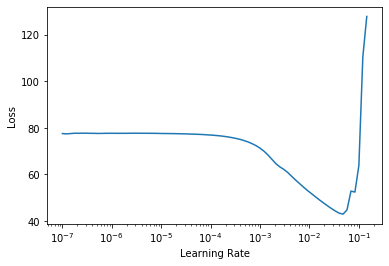

In [161]:
learn.lr_find()

epoch,train_loss,valid_loss,_exp_rmspe,time
0,0.055185,0.076386,0.276105,00:39
1,0.051488,0.049455,0.197145,00:39
2,0.044969,0.028507,0.182333,00:39
3,0.034912,0.029807,0.176419,00:39
4,0.025589,0.019015,0.150102,00:39
5,0.019733,0.018806,0.145097,00:39
6,0.015577,0.013977,0.119676,00:39
7,0.014273,0.013452,0.123373,00:39
8,0.010765,0.012673,0.119230,00:39
9,0.009418,0.011945,0.115245,00:39


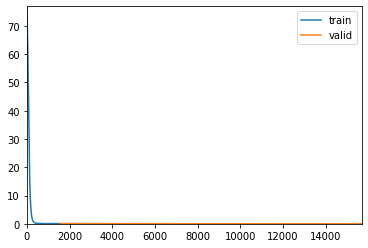

In [162]:
learn.fit_one_cycle(10, 2*1e-3, wd=0.2, cbs=[ShowGraphCallback()])

epoch,train_loss,valid_loss,_exp_rmspe,time
0,0.027368,0.034992,0.218068,00:39
1,0.025475,0.026636,0.152197,00:39
2,0.018052,0.019971,0.136794,00:39
3,0.012139,0.012589,0.113167,00:39
4,0.009784,0.011273,0.109936,00:39


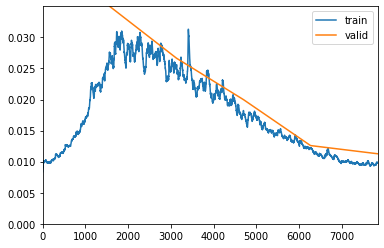

In [163]:
learn.fit_one_cycle(5, 2*1e-3, wd=0.2, cbs=[ShowGraphCallback()])

For comparison, an `exp_rmspe` of 0.108 was 10th place

## Let's see how does the model generalize to the testing set on Kaggle

In [35]:
learn.export("DL_model")

In [54]:
learn = load_learner('DL_model')

In [166]:
dl = learn.dls.test_dl(test_df)

In [167]:
#We need to tell the `Learner` to return the predictions for the test set we added

raw_test_preds = learn.get_preds(dl=dl)

test_preds_DL = torch.exp(raw_test_preds[0]).numpy().flatten()

test_df['Sales'] = test_preds_DL
test_df1 = test_df.copy()
test_df1['Sales'] = test_preds_DL

test_df[['Id', "Sales"]] = test_df[['Id', 'Sales']].astype('int')

#And finally we make our submission. **NOTE:** remove the index when generating your submission always!

test_df[['Id', 'Sales']].to_csv('submission.csv', index=False)

In [374]:
test_df1   #Its sales is not logged

,index,Id,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday,Year,...,BeforeStateHoliday,AfterPromo,BeforePromo,SchoolHoliday_bw,StateHoliday_bw,Promo_bw,SchoolHoliday_fw,StateHoliday_fw,Promo_fw,Sales
0,0,1,1,4,2015-09-17,1.0,1,False,0,2015,...,0,0,0,0.0,0.0,4.0,0.0,0.0,1.0,4056.798096
1,1,2,3,4,2015-09-17,1.0,1,False,0,2015,...,0,0,0,0.0,0.0,4.0,0.0,0.0,1.0,6797.027832
2,2,3,7,4,2015-09-17,1.0,1,False,0,2015,...,0,0,0,0.0,0.0,4.0,0.0,0.0,1.0,9932.955078
3,3,4,8,4,2015-09-17,1.0,1,False,0,2015,...,0,0,0,0.0,0.0,4.0,0.0,0.0,1.0,6227.965332
4,4,5,9,4,2015-09-17,1.0,1,False,0,2015,...,0,0,0,0.0,0.0,4.0,0.0,0.0,1.0,6329.505371
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41083,41083,41084,1111,6,2015-08-01,1.0,0,False,0,2015,...,0,1,-2,5.0,0.0,5.0,5.0,0.0,5.0,2888.308350
41084,41084,41085,1112,6,2015-08-01,1.0,0,False,0,2015,...,0,1,-2,5.0,0.0,5.0,5.0,0.0,5.0,8266.749023
41085,41085,41086,1113,6,2015-08-01,1.0,0,False,0,2015,...,0,1,-2,5.0,0.0,5.0,5.0,0.0,5.0,7107.162598
41086,41086,41087,1114,6,2015-08-01,1.0,0,False,0,2015,...,0,1,-2,5.0,0.0,5.0,5.0,0.0,5.0,23969.957031


# Let's try to see if similar store solution would help our predictions

In [55]:
# figure out stores and its state affiliations
store_state = train_df[["Store", "State"]]

store_2state = []
for i, m in store_state.groupby("Store"):
     store_2state.append(m.State.mode().values[0]) # of length 1115


states_names = ["#NA#", 'Berlin', 'Baden Wuerttemberg', 'Bayern', 'Niedersachsen/Bremen', 
                'Hessen', 'Hamburg', 'Nordrhein Westfalen', 'Rheinland Pfalz',
                'Schleswig Holstein', 'Sachsen', 'Sachsen Anhalt', 'Thueringen']

state_2statenames_dict = {i:j for i, j in zip(learn.dls.train_ds.classes["State"],states_names)}

store_2statenames = [state_2statenames_dict[i] for i in store_2state]

In [56]:
weight_matrix_store = learn.model.embeds[0].weight.cpu().detach().numpy()

In [57]:
train_df.head(5)  # The sales is logged 

,index,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,...,AfterStateHoliday,BeforeStateHoliday,AfterPromo,BeforePromo,SchoolHoliday_bw,StateHoliday_bw,Promo_bw,SchoolHoliday_fw,StateHoliday_fw,Promo_fw
0,0,1,5,2015-07-31,8.568456,555,1,1,False,1,...,57,0,0,0,5.0,0.0,5.0,7.0,0.0,5.0
1,1,2,5,2015-07-31,8.710125,625,1,1,False,1,...,67,0,0,0,5.0,0.0,5.0,1.0,0.0,1.0
2,2,3,5,2015-07-31,9.025696,821,1,1,False,1,...,57,0,0,0,5.0,0.0,5.0,5.0,0.0,5.0
3,3,4,5,2015-07-31,9.546455,1498,1,1,False,1,...,67,0,0,0,5.0,0.0,5.0,1.0,0.0,1.0
4,4,5,5,2015-07-31,8.480944,559,1,1,False,1,...,57,0,0,0,5.0,0.0,5.0,1.0,0.0,1.0


In [58]:
# Some functions to get KNN 
# Borrowed code from https://github.com/fastai/fastai/blob/master/courses/dl2/devise.ipynb
import nmslib

def create_index(a):
    index = nmslib.init(space='angulardist')
    index.addDataPointBatch(a)
    index.createIndex()
    return index

def get_knns(index, vecs):
     return zip(*index.knnQueryBatch(vecs, k=4, num_threads=4))

def get_knn(index, vec): return index.knnQuery(vec, k=10)

In [59]:
# Get knn indices from the embedding matrix
knn_indices = create_index(weight_matrix_store)

In [60]:
#find out the top three similar stores for every store
# Creat a dictionary mapping from store to closest 3 stores
stores, _ = list(get_knns(knn_indices, weight_matrix_store))
stores_3 = [stores[i][1:] for i in range(len(stores))]
close_store_dict = { i:list(j) for i,j in enumerate(stores_3)}
close_store_dict

{0: [399, 394, 1061],
 1: [912, 31, 811],
 2: [1069, 969, 642],
 3: [792, 153, 759],
 4: [104, 464, 527],
 5: [425, 1035, 828],
 6: [48, 257, 839],
 7: [1101, 729, 906],
 8: [265, 581, 404],
 9: [540, 29, 890],
 10: [511, 9, 112],
 11: [248, 862, 914],
 12: [1079, 731, 909],
 13: [795, 188, 1004],
 14: [276, 566, 1098],
 15: [139, 1062, 959],
 16: [168, 880, 901],
 17: [798, 779, 933],
 18: [329, 236, 401],
 19: [374, 996, 236],
 20: [914, 381, 665],
 21: [127, 701, 636],
 22: [879, 688, 1065],
 23: [312, 875, 242],
 24: [372, 71, 674],
 25: [125, 1033, 817],
 26: [508, 652, 185],
 27: [71, 380, 400],
 28: [949, 649, 460],
 29: [273, 540, 791],
 30: [563, 40, 829],
 31: [702, 1, 443],
 32: [970, 764, 899],
 33: [599, 1021, 525],
 34: [148, 349, 738],
 35: [545, 380, 608],
 36: [868, 1092, 539],
 37: [484, 468, 802],
 38: [244, 127, 627],
 39: [881, 664, 419],
 40: [563, 330, 114],
 41: [884, 457, 288],
 42: [697, 64, 769],
 43: [62, 1072, 617],
 44: [949, 735, 565],
 45: [874, 239, 285

In [61]:
close_store_index_df = train_df.Store.map(close_store_dict)
close_store_index_df = pd.DataFrame(close_store_index_df)

close_stores_df_three_col = pd.DataFrame(close_store_index_df['Store'].values.tolist(), 
                                         columns=['Similar1','Similar2','Similar3'])

close_stores_df_three_col["Date"] = train_df.Date

In [62]:
# create a look up table from train_df
train_lookup = train_df[["Store", "Date", "Sales"]]

In [63]:
similar_1 = close_stores_df_three_col[["Similar1", "Date"]]
similar_1.columns = ["Store", "Date"]

similar_2 = close_stores_df_three_col[["Similar2", "Date"]]
similar_2.columns = ["Store", "Date"]


similar_3 = close_stores_df_three_col[["Similar3", "Date"]]
similar_3.columns = ["Store", "Date"]

In [64]:
def similar_look_up(similar_col):
    return pd.merge(similar_col, train_lookup, on= ["Store", "Date"], how='left')["Sales"]

In [65]:
similar_1_sales = similar_look_up(similar_1)
similar_2_sales = similar_look_up(similar_2)
similar_3_sales = similar_look_up(similar_3)


In [66]:
sum(pd.isna(similar_1_sales)), sum(pd.isna(similar_2_sales)), sum(pd.isna(similar_3_sales)), 

(18405, 20968, 18381)

In [67]:
similar_df = pd.DataFrame({"similar_1": similar_1_sales ,
                         "similar_2": similar_2_sales ,
                         "similar_3": similar_3_sales })

In [68]:
full_train_df = pd.concat((train_df, similar_df), axis=1)

In [69]:
full_train_df.head()

,index,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,...,BeforePromo,SchoolHoliday_bw,StateHoliday_bw,Promo_bw,SchoolHoliday_fw,StateHoliday_fw,Promo_fw,similar_1,similar_2,similar_3
0,0,1,5,2015-07-31,8.568456,555,1,1,False,1,...,0,5.0,0.0,5.0,7.0,0.0,5.0,8.834046,8.888481,8.563122
1,1,2,5,2015-07-31,8.710125,625,1,1,False,1,...,0,5.0,0.0,5.0,1.0,0.0,1.0,8.954932,8.571681,8.208219
2,2,3,5,2015-07-31,9.025696,821,1,1,False,1,...,0,5.0,0.0,5.0,5.0,0.0,5.0,9.228279,9.035034,9.328390
3,3,4,5,2015-07-31,9.546455,1498,1,1,False,1,...,0,5.0,0.0,5.0,1.0,0.0,1.0,9.257510,9.389908,9.582593
4,4,5,5,2015-07-31,8.480944,559,1,1,False,1,...,0,5.0,0.0,5.0,1.0,0.0,1.0,8.464636,8.674710,8.989569


Note that the we successfully appended the mean sales of 3 similar stores at the end of the dataframe.

In [70]:
cat_vars = ['Store', 'DayOfWeek', 'Year', 'Month', 'Day', 'StateHoliday', 'CompetitionMonthsOpen',
    'Promo2Weeks', 'StoreType', 'Assortment', 'PromoInterval', 'CompetitionOpenSinceYear', 'Promo2SinceYear',
    'State', 'Week', 'Events', 'Promo_fw', 'Promo_bw', 'StateHoliday_fw', 'StateHoliday_bw',
    'SchoolHoliday_fw', 'SchoolHoliday_bw', 'Promo', 'SchoolHoliday']

# add "similar store" columns as continuous vars
cont_vars = ['CompetitionDistance', 'Max_TemperatureC', 'Mean_TemperatureC', 'Min_TemperatureC',
   'Max_Humidity', 'Mean_Humidity', 'Min_Humidity', 'Max_Wind_SpeedKm_h', 
   'Mean_Wind_SpeedKm_h', 'CloudCover', 'trend', 'trend_DE',
   'AfterStateHoliday', 'BeforeStateHoliday', 'similar_1', 'similar_2', 'similar_3']
   
dep_var = 'Sales'

In [71]:
to = TabularPandas(full_train_df, procs, cat_vars, cont_vars, dep_var, RegressionBlock(), splits=splits, 
                   inplace=True, reduce_memory=True)

In [72]:
dls = to.dataloaders(bs=512)

In [80]:
learn_with_similar = tabular_learner(dls, layers=[1000,500], config = config,
                        y_range=y_range, metrics=exp_rmspe,
                      loss_func=MSELossFlat())

SuggestedLRs(lr_min=4.365158383734525e-06, lr_steep=3.311311274956097e-06)

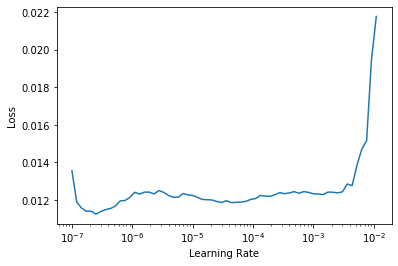

In [83]:
learn_with_similar.lr_find()

epoch,train_loss,valid_loss,_exp_rmspe,time
0,1.450746,0.074767,0.248426,00:40
1,0.035718,0.018180,0.128295,00:40
2,0.022468,0.014933,0.118809,00:40
3,0.012483,0.010680,0.107997,00:40


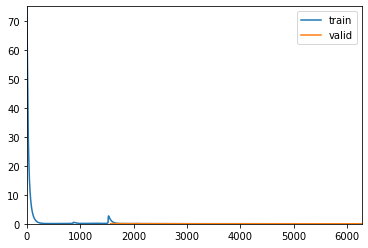

In [82]:
learn_with_similar.fit_one_cycle(4, 1e-2, wd=0.2, cbs=[ShowGraphCallback()])

In [85]:
learn_with_similar.export("Model_with_similar_log")

### Create the testing df containing the similar store sales

In [95]:
close_store_index_df = test_df1.Store.map(close_store_dict)
close_store_index_df = pd.DataFrame(close_store_index_df)

close_stores_df_three_col = pd.DataFrame(close_store_index_df['Store'].values.tolist(), 
                                         columns=['Similar1','Similar2','Similar3'])

close_stores_df_three_col["Date"] = test_df1.Date

In [96]:
close_stores_df_three_col

,Similar1,Similar2,Similar3,Date
0,912,31,811,2015-09-17
1,792,153,759,2015-09-17
2,1101,729,906,2015-09-17
3,265,581,404,2015-09-17
4,540,29,890,2015-09-17
...,...,...,...,...
41083,1109,165,619,2015-08-01
41084,753,1086,308,2015-08-01
41085,1037,359,943,2015-08-01
41086,251,523,595,2015-08-01


In [97]:
test_lookup = test_df1[["Store", "Date", "Sales"]]

In [98]:
test_lookup

,Store,Date,Sales
0,1,2015-09-17,4493.897949
1,3,2015-09-17,7620.321289
2,7,2015-09-17,9649.253906
3,8,2015-09-17,6977.445312
4,9,2015-09-17,7376.457520
...,...,...,...
41083,1111,2015-08-01,2694.324707
41084,1112,2015-08-01,6799.945312
41085,1113,2015-08-01,6318.342285
41086,1114,2015-08-01,21282.412109


In [99]:
test_lookup["Sales"] = np.log(test_lookup["Sales"])

In [100]:
similar_1 = close_stores_df_three_col[["Similar1", "Date"]]
similar_1.columns = ["Store", "Date"]

similar_2 = close_stores_df_three_col[["Similar2", "Date"]]
similar_2.columns = ["Store", "Date"]


similar_3 = close_stores_df_three_col[["Similar3", "Date"]]
similar_3.columns = ["Store", "Date"]

In [101]:
def similar_look_up(similar_col, look_up_df):
    return pd.merge(similar_col, look_up_df, on= ["Store", "Date"], how='left')["Sales"]

In [102]:
similar_1_sales = similar_look_up(similar_1, test_lookup)
similar_2_sales = similar_look_up(similar_2, test_lookup)
similar_3_sales = similar_look_up(similar_3, test_lookup)

In [103]:
sum(pd.isna(similar_1_sales)), sum(pd.isna(similar_2_sales)), sum(pd.isna(similar_3_sales)), 

(4464, 7008, 7200)

In [104]:
similar_df = pd.DataFrame({"similar_1": similar_1_sales,
                         "similar_2": similar_2_sales,
                         "similar_3": similar_3_sales })

In [105]:
similar_df

,similar_1,similar_2,similar_3
0,8.662414,8.740350,8.331995
1,8.977462,8.972328,8.926234
2,9.307403,9.299195,9.205428
3,8.631791,8.616628,8.521062
4,8.839908,9.035123,8.741735
...,...,...,...
41083,8.192669,7.978752,7.811368
41084,8.856309,8.193588,8.780865
41085,8.743432,8.829648,8.846786
41086,9.713818,NaN,NaN


In [106]:
full_test_df = pd.concat((test_df1, similar_df), axis=1)

In [107]:
full_test_df.drop("Sales", axis= 1, inplace = True)

In [108]:
full_test_df

,index,Id,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday,Year,...,BeforePromo,SchoolHoliday_bw,StateHoliday_bw,Promo_bw,SchoolHoliday_fw,StateHoliday_fw,Promo_fw,similar_1,similar_2,similar_3
0,0,1,1,4,2015-09-17,1.0,1,False,0,2015,...,0,0.0,0.0,4.0,0.0,0.0,1.0,8.662414,8.740350,8.331995
1,1,2,3,4,2015-09-17,1.0,1,False,0,2015,...,0,0.0,0.0,4.0,0.0,0.0,1.0,8.977462,8.972328,8.926234
2,2,3,7,4,2015-09-17,1.0,1,False,0,2015,...,0,0.0,0.0,4.0,0.0,0.0,1.0,9.307403,9.299195,9.205428
3,3,4,8,4,2015-09-17,1.0,1,False,0,2015,...,0,0.0,0.0,4.0,0.0,0.0,1.0,8.631791,8.616628,8.521062
4,4,5,9,4,2015-09-17,1.0,1,False,0,2015,...,0,0.0,0.0,4.0,0.0,0.0,1.0,8.839908,9.035123,8.741735
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41083,41083,41084,1111,6,2015-08-01,1.0,0,False,0,2015,...,-2,5.0,0.0,5.0,5.0,0.0,5.0,8.192669,7.978752,7.811368
41084,41084,41085,1112,6,2015-08-01,1.0,0,False,0,2015,...,-2,5.0,0.0,5.0,5.0,0.0,5.0,8.856309,8.193588,8.780865
41085,41085,41086,1113,6,2015-08-01,1.0,0,False,0,2015,...,-2,5.0,0.0,5.0,5.0,0.0,5.0,8.743432,8.829648,8.846786
41086,41086,41087,1114,6,2015-08-01,1.0,0,False,0,2015,...,-2,5.0,0.0,5.0,5.0,0.0,5.0,9.713818,NaN,NaN


In [109]:
learn_with_similar = load_learner('Model_with_similar_log')

In [110]:
dl = learn_with_similar.dls.test_dl(full_test_df)

#We need to tell the `Learner` to return the predictions for the test set we added

raw_test_preds = learn_with_similar.get_preds(dl=dl)

test_preds = np.exp(raw_test_preds[0]).numpy().flatten()

test_df['Sales'] = test_preds
test_df[['Id', "Sales"]] = test_df[['Id', 'Sales']].astype('int')

#And finally we make our submission. **NOTE:** remove the index when generating your submission always!

test_df[['Id', 'Sales']].to_csv('submission_with_similar.csv', index=False)

In [137]:
# The following function tooooo slow
# Use merge method istead for matching  multiple columns


# # Next is to find out the mean value of sales 
# def mean_sale_finder(series_similar_store):
#     ls = []
#     for i,j in enumerate(series_similar_store):  # i here refers to the index of the train_df
#         ls.append(train_df.loc[((train_df.Store == j) & (train_df.Date == train_df.Date[i])), "Sales"])
#     return ls



# Try XGBoost

In [225]:
import xgboost as xgb
from bayes_opt import BayesianOptimization


XGBoost does not handle categorical variable nicely. You need to either preprocess the catgorical vars through one hot encoding, and concatenate to the original dataset; or just let the model treats categorical integers as numerical variable

In [237]:
# Let's define the loss funtion here
def exp_rmspe(pred, targ):
    "Exp RMSE between `pred` and `targ`."
    pred, targ = np.exp(pred), np.exp(targ)
    pct_var = (targ - pred)/targ
    return np.sqrt((pct_var**2).mean())

In [44]:
X_train, y_train = to.train.xs, to.train.ys.values.ravel()
X_valid, y_valid = to.valid.xs, to.valid.ys.values.ravel()

In [27]:
index = np.random.choice(np.array(range(41396, X_train.shape[0] )), 200000)
X_train_sample = X_train.loc[index]
y_train_sample = y_train[index]

In [28]:
X_train_sample

,Store,DayOfWeek,Year,Month,Day,StateHoliday,CompetitionMonthsOpen,Promo2Weeks,StoreType,Assortment,...,Max_Humidity,Mean_Humidity,Min_Humidity,Max_Wind_SpeedKm_h,Mean_Wind_SpeedKm_h,CloudCover,trend,trend_DE,AfterStateHoliday,BeforeStateHoliday
527779,57,5,1,12,6,1,1,1,4,3,...,0.877884,-0.111221,0.122481,2.705215,3.881814,0.255604,1.854770,1.463722,-0.701135,0.599161
183310,413,4,3,1,15,1,5,1,1,3,...,0.877884,0.885645,0.529760,-1.065403,-1.152075,0.255604,0.042582,-0.374736,-0.922376,-1.218356
172665,945,2,3,1,27,1,25,1,1,3,...,0.877884,0.578917,0.427940,-0.178199,0.190296,-1.594353,-0.772903,0.706710,-0.385078,-0.848691
585823,753,1,1,10,7,1,11,26,4,3,...,0.615005,0.042143,-0.590257,-1.065403,-1.152075,-1.594353,-0.954122,-1.023604,-1.080405,0.414329
88298,465,1,3,4,27,1,25,1,4,3,...,0.877884,1.039009,0.987948,0.709005,-0.145297,0.872256,1.129895,0.814854,-0.543107,1.061242
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
441803,924,2,2,3,11,1,25,26,1,1,...,-0.042192,-0.264585,-0.641166,0.709005,0.693685,0.255604,0.314410,0.490420,0.973970,0.013859
407999,636,2,2,4,15,1,25,26,3,1,...,-0.830828,-0.341267,0.326120,0.487204,1.532666,0.255604,-1.316560,-1.023604,1.922143,1.092047
777342,805,3,1,3,13,1,18,1,4,1,...,-0.042192,1.039009,1.547956,-0.400000,0.190296,0.255604,0.133191,-0.374736,0.879152,0.691577
140855,356,6,3,2,28,1,25,26,4,3,...,-0.042192,0.272189,-0.132068,-0.400000,-0.313093,-0.977701,1.129895,0.598565,0.468278,0.137081


In [246]:
learn = load_learner('DL_model')
dl = learn.dls.test_dl(test_df)

In [247]:
processed_test_df = dl.xs 
processed_test_df.head()

,Store,DayOfWeek,Year,Month,Day,StateHoliday,CompetitionMonthsOpen,Promo2Weeks,StoreType,Assortment,...,Max_Humidity,Mean_Humidity,Min_Humidity,Max_Wind_SpeedKm_h,Mean_Wind_SpeedKm_h,CloudCover,trend,trend_DE,AfterStateHoliday,BeforeStateHoliday
0,1,4,3,9,17,1,25,1,3,1,...,0.877884,1.575783,1.904325,0.709005,0.358092,0.255604,0.405019,0.165987,2.111777,1.184463
1,3,4,3,9,17,1,25,26,1,1,...,0.877884,0.272189,0.377030,1.596209,2.371647,0.255604,0.314410,0.165987,2.111777,1.184463
2,7,4,3,9,17,1,25,1,1,3,...,0.352126,-0.111221,0.529760,0.709005,0.358092,-0.361048,-0.501075,0.165987,2.427835,1.184463
3,8,4,3,9,17,1,12,1,1,1,...,0.352126,-0.111221,0.529760,0.709005,0.358092,-0.361048,-0.501075,0.165987,2.427835,1.184463
4,9,4,3,9,17,1,25,1,1,3,...,0.877884,0.272189,0.377030,1.596209,2.371647,0.255604,0.314410,0.165987,2.111777,1.184463


In [44]:
def fit_with(max_depth:float, gamma:float, n_estimators:float,learning_rate:float):
    max_depth = int(max_depth) # Turn this into int, otherwise it will not work! 
    n_estimators = int(n_estimators) # Turn this into int, otherwise it will not work!
    model = xgb.XGBRegressor(n_estimators = n_estimators, max_depth= max_depth, 
                             learning_rate=learning_rate, gamma = gamma)
    xgb_model = model.fit(X_train, y_train)
    pred = xgb_model.predict(X_valid)
  
    return -float(exp_rmspe(pred, y_valid))

In [45]:
params = {'max_depth': (3, 10), 
          'gamma': (0, 1),
          'learning_rate': (0, 1),
          'n_estimators': (100, 120)}

In [46]:
optim = BayesianOptimization(
    f = fit_with, # our fit function
    pbounds = params)

In [47]:
optim.maximize(n_iter = 10)

|   iter    |  target   |   gamma   | learni... | max_depth | n_esti... |
-------------------------------------------------------------------------
|  1        | -0.3409   |  0.02869  |  0.1124   |  4.044    |  102.2    |
|  2        | -0.2498   |  0.1817   |  0.5732   |  3.104    |  116.2    |
|  3        | -0.1684   |  0.1874   |  0.9535   |  5.744    |  109.1    |
|  4        | -0.2702   |  0.3047   |  0.263    |  4.735    |  108.4    |
|  5        | -0.2004   |  0.9627   |  0.595    |  4.728    |  116.7    |
|  6        | -0.2825   |  0.0      |  1.0      |  10.0     |  120.0    |
|  7        | -0.2118   |  1.0      |  1.0      |  10.0     |  100.0    |
|  8        | -0.2118   |  1.0      |  1.0      |  10.0     |  111.4    |
|  9        | -0.2643   |  1.0      |  1.0      |  3.0      |  120.0    |
|  10       | -0.2802   |  0.0      |  1.0      |  10.0     |  104.8    |
|  11       | -0.2697   |  1.0      |  1.0      |  3.0      |  111.6    |
|  12       | -0.2066   |  0.0      | 

In [48]:
optim.max

{'target': -0.16837753412323578,
 'params': {'gamma': 0.18737473609037647,
  'learning_rate': 0.95346399864783,
  'max_depth': 5.744014828349802,
  'n_estimators': 109.11975197901292}}

In [94]:
model = xgb.XGBRegressor(n_estimators = 110, max_depth=6, learning_rate=0.9534, subsample=0.5)

In [95]:
xgb_model = model.fit(X_train, y_train)

In [96]:
pred = model.predict(processed_test_df)

test_preds_xgboost = np.exp(pred)


In [62]:
test_df['Sales'] = test_preds_xgboost
test_df[['Id', "Sales"]] = test_df[['Id', 'Sales']].astype('int')

#And finally we make our submission. **NOTE:** remove the index when generating your submission always!

test_df[['Id', 'Sales']].to_csv('submission_xgboost.csv', index=False)

XGBOOST alone leads to a 0.20 rmspe which leads us to the 2714th place in the leader board compared with the first DL model which leads to a 0.10 rmspe, 10th place on the leader board.

# Try lightgbm

Lightgbm could handle categorical variable by taking the "categorical_feature" arguments in its Dataset and also its Training API. 

In [224]:
import lightgbm as lgb


In [82]:
train_lgb = lgb.Dataset(X_train,  categorical_feature= cat_vars, label=y_train)
valid_lgb = lgb.Dataset(X_valid, categorical_feature= cat_vars, label = y_valid)

In [125]:
def fit_with(max_depth:int,  n_estimators:int, learning_rate:float, num_leaves: int, 
            bagging_fraction:float, feature_fraction:float):
    max_depth = int(max_depth) # Turn this into int, otherwise it will not work! 
    n_estimators = int(n_estimators) # Turn this into int, otherwise it will not work!
    num_leaves = int(num_leaves)
    model = lgb.LGBMRegressor(n_estimators = n_estimators, max_depth= max_depth, 
                             learning_rate=learning_rate, bagging_fraction = bagging_fraction,
                             feature_fraction = feature_fraction, num_leaves = num_leaves)
    lgb_model = model.fit(X_train, y_train)
    pred = lgb_model.predict(X_valid)
  
    return -float(exp_rmspe(pred, y_valid))

# def the param ranges to finetune
params = {"max_depth": (25, 75),
              "learning_rate" : (0.001, 1),
              "num_leaves": (200, 1200),
              "n_estimators": (200, 500),
          "feature_fraction": (0.5, 1),
          'bagging_fraction': (0.5, 1)
             }

In [127]:
optim = BayesianOptimization(
    f = fit_with, # our fit function
    pbounds = params)

optim.maximize(n_iter = 25, init_points= 10)

In [132]:
optim.max

{'target': -0.12444423787525713,
 'params': {'bagging_fraction': 0.8735517297826776,
  'feature_fraction': 0.7403032052745127,
  'learning_rate': 0.037262515871608407,
  'max_depth': 73.561920263003,
  'n_estimators': 400.53632637344083,
  'num_leaves': 1199.5316871516538}}

In [85]:
parameters = {
    'objective': 'regression',
    'boosting': 'gbdt',
    'num_leaves': 1200,
    'bagging_fraction': 0.8735517297826776,
     'feature_fraction': 0.7403032052745127,
     'learning_rate': 0.037262515871608407,
     'max_depth': 73,
     'n_estimators': 400,
}

In [86]:
model = lgb.train(parameters,
                       train_lgb,
                       valid_sets= valid_lgb,
                       early_stopping_rounds=100,
                 categorical_feature= cat_vars)

[1]	valid_0's l2: 0.16186
Training until validation scores don't improve for 100 rounds
[2]	valid_0's l2: 0.157169
[3]	valid_0's l2: 0.147596
[4]	valid_0's l2: 0.140859
[5]	valid_0's l2: 0.134387
[6]	valid_0's l2: 0.127737
[7]	valid_0's l2: 0.120155
[8]	valid_0's l2: 0.115423
[9]	valid_0's l2: 0.108742
[10]	valid_0's l2: 0.102377
[11]	valid_0's l2: 0.0981108
[12]	valid_0's l2: 0.0927356
[13]	valid_0's l2: 0.0876522
[14]	valid_0's l2: 0.084382
[15]	valid_0's l2: 0.079633
[16]	valid_0's l2: 0.0754538
[17]	valid_0's l2: 0.0729134
[18]	valid_0's l2: 0.0693544
[19]	valid_0's l2: 0.0669124
[20]	valid_0's l2: 0.0635977
[21]	valid_0's l2: 0.0615144
[22]	valid_0's l2: 0.0586236
[23]	valid_0's l2: 0.0558023
[24]	valid_0's l2: 0.0532916
[25]	valid_0's l2: 0.0509783
[26]	valid_0's l2: 0.0497203
[27]	valid_0's l2: 0.047576
[28]	valid_0's l2: 0.046553
[29]	valid_0's l2: 0.0453417
[30]	valid_0's l2: 0.0435883
[31]	valid_0's l2: 0.0419157
[32]	valid_0's l2: 0.0410887
[33]	valid_0's l2: 0.0400323
[34]	

[278]	valid_0's l2: 0.0134323
[279]	valid_0's l2: 0.013431
[280]	valid_0's l2: 0.0134221
[281]	valid_0's l2: 0.0134166
[282]	valid_0's l2: 0.0134093
[283]	valid_0's l2: 0.0134074
[284]	valid_0's l2: 0.0134071
[285]	valid_0's l2: 0.0134041
[286]	valid_0's l2: 0.0133955
[287]	valid_0's l2: 0.0133907
[288]	valid_0's l2: 0.0133882
[289]	valid_0's l2: 0.0133819
[290]	valid_0's l2: 0.0133729
[291]	valid_0's l2: 0.0133578
[292]	valid_0's l2: 0.0133499
[293]	valid_0's l2: 0.0133484
[294]	valid_0's l2: 0.0133465
[295]	valid_0's l2: 0.0133426
[296]	valid_0's l2: 0.0133396
[297]	valid_0's l2: 0.0133387
[298]	valid_0's l2: 0.0133309
[299]	valid_0's l2: 0.0133254
[300]	valid_0's l2: 0.0133233
[301]	valid_0's l2: 0.0133202
[302]	valid_0's l2: 0.0133132
[303]	valid_0's l2: 0.0133039
[304]	valid_0's l2: 0.0133024
[305]	valid_0's l2: 0.0132987
[306]	valid_0's l2: 0.0132971
[307]	valid_0's l2: 0.0132911
[308]	valid_0's l2: 0.013289
[309]	valid_0's l2: 0.0132886
[310]	valid_0's l2: 0.0132866
[311]	valid_

In [87]:
pred = model.predict(processed_test_df, categorical_feature = cat_vars)

In [88]:
test_preds_lightgbm = np.exp(pred)


test_df['Sales'] = test_preds_lightgbm
test_df[['Id', "Sales"]] = test_df[['Id', 'Sales']].astype('int')

#And finally we make our submission. **NOTE:** remove the index when generating your submission always!

test_df[['Id', 'Sales']].to_csv('submission_lightgbm_finetuned.csv', index=False)

# Try Catboost

In [22]:
import catboost

In [28]:
model = catboost.CatBoostRegressor(100, learning_rate= 0.1, depth = 7, 
                                   loss_function = "RMSE",
                                  task_type='GPU',
                                  early_stopping_rounds=20)

In [44]:
def fit_with(depth,  iterations, learning_rate:float, l2_leaf_reg):
    iterations = int(iterations) # Turn this into int, otherwise it will not work! 
    depth = int(depth) # Turn this into int, otherwise it will not work!
    l2_leaf_reg = int(l2_leaf_reg)
    
    model = catboost.CatBoostRegressor(iterations, learning_rate= learning_rate, depth = depth, 
                                       l2_leaf_reg = l2_leaf_reg,
                                   loss_function = "RMSE",
                                  task_type='GPU',
                                  early_stopping_rounds=20)
    model.fit(
    X_train, y_train,
    cat_features=cat_vars,
    #eval_set=(X_valid, y_valid),
   # plot=True,
    verbose = 10)
    
    pred = model.predict(X_valid)
  
    return -float(exp_rmspe(pred, y_valid))

In [45]:
params = {'depth': (4, 10),
          'learning_rate' : (0.001, 1),
         'l2_leaf_reg': (1, 9),
         'iterations': (100, 600)}

In [46]:
optim = BayesianOptimization(
    f = fit_with, # our fit function
    pbounds = params)

In [49]:
optim.maximize(n_iter = 20, init_points= 15)

|   iter    |  target   |   depth   | iterat... | l2_lea... | learni... |
-------------------------------------------------------------------------
0:	learn: 0.2302716	total: 470ms	remaining: 2m 3s
10:	learn: 0.1686140	total: 4.18s	remaining: 1m 36s
20:	learn: 0.1526956	total: 7.94s	remaining: 1m 31s
30:	learn: 0.1467732	total: 12s	remaining: 1m 30s
40:	learn: 0.1415445	total: 15.6s	remaining: 1m 24s
50:	learn: 0.1391270	total: 19s	remaining: 1m 19s
60:	learn: 0.1360361	total: 22.4s	remaining: 1m 14s
70:	learn: 0.1335274	total: 26.1s	remaining: 1m 10s
80:	learn: 0.1317713	total: 29.4s	remaining: 1m 6s
90:	learn: 0.1303733	total: 32.7s	remaining: 1m 2s
100:	learn: 0.1290277	total: 36.1s	remaining: 58.3s
110:	learn: 0.1281001	total: 39.7s	remaining: 54.7s
120:	learn: 0.1269910	total: 43.6s	remaining: 51.5s
130:	learn: 0.1259743	total: 47.1s	remaining: 47.8s
140:	learn: 0.1244541	total: 50.5s	remaining: 44s
150:	learn: 0.1235573	total: 54.2s	remaining: 40.6s
160:	learn: 0.1225189	total: 5

0:	learn: 0.3714576	total: 498ms	remaining: 4m 47s
10:	learn: 0.1915674	total: 5.13s	remaining: 4m 24s
20:	learn: 0.1663161	total: 9.08s	remaining: 4m
30:	learn: 0.1565051	total: 13.5s	remaining: 3m 57s
40:	learn: 0.1494364	total: 17.9s	remaining: 3m 54s
50:	learn: 0.1449452	total: 22.4s	remaining: 3m 51s
60:	learn: 0.1401172	total: 26.5s	remaining: 3m 44s
70:	learn: 0.1368624	total: 30.9s	remaining: 3m 40s
80:	learn: 0.1341098	total: 35s	remaining: 3m 34s
90:	learn: 0.1321190	total: 39.1s	remaining: 3m 29s
100:	learn: 0.1300119	total: 43.5s	remaining: 3m 25s
110:	learn: 0.1281616	total: 47.9s	remaining: 3m 21s
120:	learn: 0.1266914	total: 51.8s	remaining: 3m 15s
130:	learn: 0.1253585	total: 56s	remaining: 3m 10s
140:	learn: 0.1242096	total: 59.8s	remaining: 3m 5s
150:	learn: 0.1230486	total: 1m 3s	remaining: 3m
160:	learn: 0.1220880	total: 1m 7s	remaining: 2m 55s
170:	learn: 0.1213352	total: 1m 11s	remaining: 2m 50s
180:	learn: 0.1205678	total: 1m 15s	remaining: 2m 45s
190:	learn: 0.1

80:	learn: 0.1816124	total: 25.6s	remaining: 1m 35s
90:	learn: 0.1778856	total: 28.5s	remaining: 1m 31s
100:	learn: 0.1748578	total: 31.5s	remaining: 1m 28s
110:	learn: 0.1726586	total: 34.5s	remaining: 1m 24s
120:	learn: 0.1708095	total: 37.3s	remaining: 1m 21s
130:	learn: 0.1690993	total: 40.1s	remaining: 1m 17s
140:	learn: 0.1675118	total: 43.1s	remaining: 1m 14s
150:	learn: 0.1660681	total: 46s	remaining: 1m 11s
160:	learn: 0.1648807	total: 48.9s	remaining: 1m 7s
170:	learn: 0.1639304	total: 52.1s	remaining: 1m 4s
180:	learn: 0.1629573	total: 55.1s	remaining: 1m 1s
190:	learn: 0.1618429	total: 58s	remaining: 58.6s
200:	learn: 0.1609294	total: 1m	remaining: 55.5s
210:	learn: 0.1601183	total: 1m 3s	remaining: 52.4s
220:	learn: 0.1593484	total: 1m 6s	remaining: 49.4s
230:	learn: 0.1584357	total: 1m 9s	remaining: 46.3s
240:	learn: 0.1577008	total: 1m 12s	remaining: 43.2s
250:	learn: 0.1570565	total: 1m 15s	remaining: 40.2s
260:	learn: 0.1563980	total: 1m 18s	remaining: 37.2s
270:	learn

350:	learn: 0.1103458	total: 2m 24s	remaining: 3.69s
359:	learn: 0.1099950	total: 2m 27s	remaining: 0us
|  12       | -0.1341   |  9.914    |  360.0    |  3.752    |  0.1908   |
0:	learn: 0.4085310	total: 528ms	remaining: 1m 46s
10:	learn: 0.2869645	total: 5.08s	remaining: 1m 28s
20:	learn: 0.2282446	total: 9.51s	remaining: 1m 22s
30:	learn: 0.2008631	total: 14s	remaining: 1m 17s
40:	learn: 0.1866909	total: 18.3s	remaining: 1m 12s
50:	learn: 0.1777441	total: 22.6s	remaining: 1m 7s
60:	learn: 0.1707629	total: 26.6s	remaining: 1m 1s
70:	learn: 0.1642703	total: 30.9s	remaining: 57.4s
80:	learn: 0.1595664	total: 35s	remaining: 52.7s
90:	learn: 0.1567492	total: 39.2s	remaining: 48.2s
100:	learn: 0.1537905	total: 43.3s	remaining: 43.7s
110:	learn: 0.1518298	total: 47.4s	remaining: 39.3s
120:	learn: 0.1499838	total: 51.8s	remaining: 35.1s
130:	learn: 0.1477769	total: 56.3s	remaining: 30.9s
140:	learn: 0.1461788	total: 1m	remaining: 26.6s
150:	learn: 0.1445340	total: 1m 4s	remaining: 22.3s
160

100:	learn: 0.1613923	total: 1.93s	remaining: 995ms
110:	learn: 0.1598295	total: 2.1s	remaining: 795ms
120:	learn: 0.1586274	total: 2.28s	remaining: 602ms
130:	learn: 0.1574938	total: 2.46s	remaining: 412ms
140:	learn: 0.1566081	total: 2.63s	remaining: 224ms
150:	learn: 0.1557304	total: 2.81s	remaining: 37.2ms
152:	learn: 0.1556575	total: 2.84s	remaining: 0us
|  17       | -0.1752   |  4.134    |  153.5    |  3.455    |  0.4818   |
0:	learn: 0.2855483	total: 339ms	remaining: 2m 5s
10:	learn: 0.1884222	total: 3.08s	remaining: 1m 41s
20:	learn: 0.1731937	total: 5.73s	remaining: 1m 35s
30:	learn: 0.1659625	total: 8.35s	remaining: 1m 31s
40:	learn: 0.1615361	total: 10.9s	remaining: 1m 28s
50:	learn: 0.1579856	total: 13.4s	remaining: 1m 24s
60:	learn: 0.1556294	total: 15.9s	remaining: 1m 21s
70:	learn: 0.1521645	total: 18.3s	remaining: 1m 17s
80:	learn: 0.1499215	total: 20.9s	remaining: 1m 15s
90:	learn: 0.1482146	total: 23.3s	remaining: 1m 12s
100:	learn: 0.1462797	total: 25.6s	remaining: 

200:	learn: 0.1170057	total: 1m 22s	remaining: 20s
210:	learn: 0.1163853	total: 1m 26s	remaining: 15.9s
220:	learn: 0.1159311	total: 1m 30s	remaining: 11.9s
230:	learn: 0.1153981	total: 1m 34s	remaining: 7.78s
240:	learn: 0.1146971	total: 1m 38s	remaining: 3.69s
249:	learn: 0.1140127	total: 1m 42s	remaining: 0us
|  22       | -0.1752   |  9.604    |  250.3    |  7.3      |  0.2264   |
0:	learn: 0.2668792	total: 455ms	remaining: 1m 51s
10:	learn: 0.1787054	total: 3.32s	remaining: 1m 11s
20:	learn: 0.1654487	total: 6.29s	remaining: 1m 7s
30:	learn: 0.1579849	total: 9.1s	remaining: 1m 3s
40:	learn: 0.1522313	total: 12.1s	remaining: 1m 1s
50:	learn: 0.1480311	total: 14.9s	remaining: 57.3s
60:	learn: 0.1449960	total: 17.8s	remaining: 54.4s
70:	learn: 0.1434079	total: 20.6s	remaining: 51s
80:	learn: 0.1413407	total: 23.3s	remaining: 47.8s
90:	learn: 0.1397313	total: 26.2s	remaining: 44.9s
100:	learn: 0.1379504	total: 29.1s	remaining: 42s
110:	learn: 0.1369286	total: 32s	remaining: 39.2s
120:

|  27       | -0.1615   |  4.691    |  181.0    |  6.111    |  0.8887   |
0:	learn: 0.3975082	total: 30.7ms	remaining: 4.33s
10:	learn: 0.2587992	total: 310ms	remaining: 3.69s
20:	learn: 0.2254341	total: 561ms	remaining: 3.23s
30:	learn: 0.2128529	total: 781ms	remaining: 2.8s
40:	learn: 0.2032515	total: 1.01s	remaining: 2.5s
50:	learn: 0.1969820	total: 1.23s	remaining: 2.2s
60:	learn: 0.1917216	total: 1.45s	remaining: 1.93s
70:	learn: 0.1886990	total: 1.68s	remaining: 1.68s
80:	learn: 0.1852569	total: 1.9s	remaining: 1.43s
90:	learn: 0.1823049	total: 2.12s	remaining: 1.19s
100:	learn: 0.1803110	total: 2.34s	remaining: 949ms
110:	learn: 0.1781883	total: 2.54s	remaining: 711ms
120:	learn: 0.1767521	total: 2.76s	remaining: 479ms
130:	learn: 0.1751742	total: 2.97s	remaining: 250ms
140:	learn: 0.1732645	total: 3.2s	remaining: 22.7ms
141:	learn: 0.1731783	total: 3.22s	remaining: 0us
|  28       | -0.2112   |  5.052    |  142.3    |  2.01     |  0.1032   |
0:	learn: 0.4044086	total: 47.1ms	re

100:	learn: 0.1464835	total: 25.3s	remaining: 31.1s
110:	learn: 0.1449449	total: 27.8s	remaining: 28.5s
120:	learn: 0.1434315	total: 30.2s	remaining: 26s
130:	learn: 0.1424687	total: 32.6s	remaining: 23.4s
140:	learn: 0.1413384	total: 35s	remaining: 20.9s
150:	learn: 0.1408284	total: 37.4s	remaining: 18.3s
160:	learn: 0.1401341	total: 39.8s	remaining: 15.8s
170:	learn: 0.1389496	total: 42.4s	remaining: 13.4s
180:	learn: 0.1380556	total: 44.9s	remaining: 10.9s
190:	learn: 0.1371405	total: 47.4s	remaining: 8.44s
200:	learn: 0.1361227	total: 50s	remaining: 5.97s
210:	learn: 0.1355941	total: 52.5s	remaining: 3.48s
220:	learn: 0.1350847	total: 54.8s	remaining: 991ms
224:	learn: 0.1349650	total: 55.7s	remaining: 0us
|  32       | -0.1511   |  4.063    |  225.6    |  8.97     |  0.6166   |
0:	learn: 0.2196239	total: 529ms	remaining: 2m 58s
10:	learn: 0.1549505	total: 4.68s	remaining: 2m 19s
20:	learn: 0.1419434	total: 8.85s	remaining: 2m 13s
30:	learn: 0.1333332	total: 13.2s	remaining: 2m 10s

120:	learn: 0.1274298	total: 51.7s	remaining: 2m 50s
130:	learn: 0.1259188	total: 55.8s	remaining: 2m 46s
140:	learn: 0.1247463	total: 1m	remaining: 2m 41s
150:	learn: 0.1235883	total: 1m 3s	remaining: 2m 36s
160:	learn: 0.1224829	total: 1m 7s	remaining: 2m 31s
170:	learn: 0.1215823	total: 1m 11s	remaining: 2m 27s
180:	learn: 0.1206591	total: 1m 16s	remaining: 2m 23s
190:	learn: 0.1201734	total: 1m 20s	remaining: 2m 19s
200:	learn: 0.1195233	total: 1m 24s	remaining: 2m 14s
210:	learn: 0.1186376	total: 1m 28s	remaining: 2m 9s
220:	learn: 0.1176938	total: 1m 32s	remaining: 2m 5s
230:	learn: 0.1171860	total: 1m 36s	remaining: 2m
240:	learn: 0.1165601	total: 1m 40s	remaining: 1m 56s
250:	learn: 0.1156889	total: 1m 44s	remaining: 1m 52s
260:	learn: 0.1149314	total: 1m 48s	remaining: 1m 48s
270:	learn: 0.1144222	total: 1m 53s	remaining: 1m 44s
280:	learn: 0.1139266	total: 1m 56s	remaining: 1m 39s
290:	learn: 0.1132399	total: 2m 1s	remaining: 1m 35s
300:	learn: 0.1127727	total: 2m 4s	remainin

300:	learn: 0.1311355	total: 1m 14s	remaining: 1m 7s
310:	learn: 0.1307319	total: 1m 16s	remaining: 1m 4s
320:	learn: 0.1303936	total: 1m 19s	remaining: 1m 2s
330:	learn: 0.1301561	total: 1m 21s	remaining: 59.8s
340:	learn: 0.1297671	total: 1m 24s	remaining: 57.3s
350:	learn: 0.1295304	total: 1m 26s	remaining: 54.8s
360:	learn: 0.1292147	total: 1m 29s	remaining: 52.3s
370:	learn: 0.1287753	total: 1m 31s	remaining: 50s
380:	learn: 0.1284460	total: 1m 34s	remaining: 47.5s
390:	learn: 0.1281568	total: 1m 36s	remaining: 45s
400:	learn: 0.1279672	total: 1m 38s	remaining: 42.4s
410:	learn: 0.1277650	total: 1m 41s	remaining: 39.9s
420:	learn: 0.1274688	total: 1m 43s	remaining: 37.4s
430:	learn: 0.1271011	total: 1m 45s	remaining: 34.9s
440:	learn: 0.1268257	total: 1m 48s	remaining: 32.4s
450:	learn: 0.1266015	total: 1m 50s	remaining: 29.9s
460:	learn: 0.1262554	total: 1m 53s	remaining: 27.5s
470:	learn: 0.1260124	total: 1m 55s	remaining: 25s
480:	learn: 0.1258683	total: 1m 57s	remaining: 22.5s

KeyboardInterrupt: 

In [49]:
params = {"depth": 10, 
          "iterations":  360, 
          "l2_leaf_reg"  : 3.752,   
          "learning_rate" : 0.1908,
         "one_hot_max_size" : 10}

In [50]:
model = catboost.CatBoostRegressor(**params,
                                   loss_function = "RMSE",
                                  task_type='GPU',
                                  early_stopping_rounds=40)

In [51]:
%time model.fit(X_train, y_train, cat_features=cat_vars, eval_set=(X_valid, y_valid))
   # plot=True)

0:	learn: 0.3689937	test: 0.3570981	best: 0.3570981 (0)	total: 477ms	remaining: 2m 51s
1:	learn: 0.3255838	test: 0.3158594	best: 0.3158594 (1)	total: 854ms	remaining: 2m 32s
2:	learn: 0.2923226	test: 0.2829140	best: 0.2829140 (2)	total: 1.21s	remaining: 2m 24s
3:	learn: 0.2672610	test: 0.2574065	best: 0.2574065 (3)	total: 1.59s	remaining: 2m 21s
4:	learn: 0.2487087	test: 0.2403668	best: 0.2403668 (4)	total: 1.89s	remaining: 2m 14s
5:	learn: 0.2317175	test: 0.2241958	best: 0.2241958 (5)	total: 2.23s	remaining: 2m 11s
6:	learn: 0.2197194	test: 0.2130557	best: 0.2130557 (6)	total: 2.65s	remaining: 2m 13s
7:	learn: 0.2111033	test: 0.2050639	best: 0.2050639 (7)	total: 2.95s	remaining: 2m 9s
8:	learn: 0.2044858	test: 0.2016399	best: 0.2016399 (8)	total: 3.29s	remaining: 2m 8s
9:	learn: 0.1993584	test: 0.1976321	best: 0.1976321 (9)	total: 3.62s	remaining: 2m 6s
10:	learn: 0.1925773	test: 0.1915256	best: 0.1915256 (10)	total: 3.97s	remaining: 2m 5s
11:	learn: 0.1883480	test: 0.1896375	best: 0.

93:	learn: 0.1256138	test: 0.1453871	best: 0.1453871 (93)	total: 33.7s	remaining: 1m 35s
94:	learn: 0.1254909	test: 0.1453337	best: 0.1453337 (94)	total: 34.1s	remaining: 1m 35s
95:	learn: 0.1253475	test: 0.1454868	best: 0.1453337 (94)	total: 34.5s	remaining: 1m 34s
96:	learn: 0.1252389	test: 0.1454152	best: 0.1453337 (94)	total: 34.8s	remaining: 1m 34s
97:	learn: 0.1248276	test: 0.1450835	best: 0.1450835 (97)	total: 35.2s	remaining: 1m 34s
98:	learn: 0.1244126	test: 0.1447647	best: 0.1447647 (98)	total: 35.5s	remaining: 1m 33s
99:	learn: 0.1240968	test: 0.1445114	best: 0.1445114 (99)	total: 35.8s	remaining: 1m 33s
100:	learn: 0.1239669	test: 0.1442722	best: 0.1442722 (100)	total: 36.1s	remaining: 1m 32s
101:	learn: 0.1238187	test: 0.1434982	best: 0.1434982 (101)	total: 36.5s	remaining: 1m 32s
102:	learn: 0.1235995	test: 0.1433289	best: 0.1433289 (102)	total: 36.8s	remaining: 1m 31s
103:	learn: 0.1234233	test: 0.1432192	best: 0.1432192 (103)	total: 37.2s	remaining: 1m 31s
104:	learn: 0

184:	learn: 0.1135832	test: 0.1368242	best: 0.1368242 (184)	total: 1m 3s	remaining: 1m
185:	learn: 0.1134594	test: 0.1367364	best: 0.1367364 (185)	total: 1m 4s	remaining: 1m
186:	learn: 0.1133838	test: 0.1367280	best: 0.1367280 (186)	total: 1m 4s	remaining: 59.8s
187:	learn: 0.1132053	test: 0.1366180	best: 0.1366180 (187)	total: 1m 4s	remaining: 59.4s
188:	learn: 0.1131519	test: 0.1367083	best: 0.1366180 (187)	total: 1m 5s	remaining: 59.1s
189:	learn: 0.1130864	test: 0.1365924	best: 0.1365924 (189)	total: 1m 5s	remaining: 58.8s
190:	learn: 0.1129321	test: 0.1365878	best: 0.1365878 (190)	total: 1m 6s	remaining: 58.4s
191:	learn: 0.1127897	test: 0.1364061	best: 0.1364061 (191)	total: 1m 6s	remaining: 58s
192:	learn: 0.1127285	test: 0.1363659	best: 0.1363659 (192)	total: 1m 6s	remaining: 57.6s
193:	learn: 0.1126802	test: 0.1363509	best: 0.1363509 (193)	total: 1m 7s	remaining: 57.3s
194:	learn: 0.1126117	test: 0.1362817	best: 0.1362817 (194)	total: 1m 7s	remaining: 57s
195:	learn: 0.112461

275:	learn: 0.1077334	test: 0.1331893	best: 0.1331367 (273)	total: 1m 35s	remaining: 29s
276:	learn: 0.1077173	test: 0.1332499	best: 0.1331367 (273)	total: 1m 35s	remaining: 28.7s
277:	learn: 0.1076697	test: 0.1332051	best: 0.1331367 (273)	total: 1m 35s	remaining: 28.3s
278:	learn: 0.1076525	test: 0.1331616	best: 0.1331367 (273)	total: 1m 36s	remaining: 28s
279:	learn: 0.1076279	test: 0.1331353	best: 0.1331353 (279)	total: 1m 36s	remaining: 27.6s
280:	learn: 0.1075751	test: 0.1331457	best: 0.1331353 (279)	total: 1m 36s	remaining: 27.3s
281:	learn: 0.1074988	test: 0.1330717	best: 0.1330717 (281)	total: 1m 37s	remaining: 26.9s
282:	learn: 0.1074596	test: 0.1330747	best: 0.1330717 (281)	total: 1m 37s	remaining: 26.6s
283:	learn: 0.1074241	test: 0.1330824	best: 0.1330717 (281)	total: 1m 37s	remaining: 26.2s
284:	learn: 0.1074004	test: 0.1330943	best: 0.1330717 (281)	total: 1m 38s	remaining: 25.9s
285:	learn: 0.1073335	test: 0.1330454	best: 0.1330454 (285)	total: 1m 38s	remaining: 25.5s
286

In [52]:
pred = model.predict(processed_test_df)

test_preds_catgbm = np.exp(pred)


test_df['Sales'] = test_preds_catgbm
test_df[['Id', "Sales"]] = test_df[['Id', 'Sales']].astype('int')

#And finally we make our submission. **NOTE:** remove the index when generating your submission always!

test_df[['Id', 'Sales']].to_csv('submission_catgbm_finetuned.csv', index=False)

# Simple ensemble them by averaging them

In [109]:
# ensemble of LightBGM and DL models   Improved the model a little bit more
test_df['Sales'] = (test_preds_DL + test_preds_lightgbm)/2
test_df[['Id', "Sales"]] = test_df[['Id', 'Sales']].astype('int')

#And finally we make our submission. **NOTE:** remove the index when generating your submission always!

test_df[['Id', 'Sales']].to_csv('submission_ensemble_lightDL.csv', index=False)

# Let's feed the embeddings to lightgbm to see if it is helpful

In [238]:
# Let's define the loss funtion here
def exp_rmspe(pred, targ):
    "Exp RMSE between `pred` and `targ`."
    pred, targ = np.exp(pred), np.exp(targ)
    pct_var = (targ - pred)/targ
    return np.sqrt((pct_var**2).mean())

In [172]:
store_2emd = {i:j for i, j in zip(learn.dls.train_ds.classes["Store"], weight_matrix_store )}

In [ ]:
store_column = train_df.Store.map(store_2emd)

store_emd_df = pd.DataFrame(store_column.to_list(), )

store_emd_df.columns = [f'emb_{i}' for i in range(81) ]

In [331]:
train_emd = pd.concat((train_df, store_emd_df), axis = 1)

In [332]:
cat_vars = ['Store', 'DayOfWeek', 'Year', 'Month', 'Day', 'StateHoliday', 'CompetitionMonthsOpen',
    'Promo2Weeks', 'StoreType', 'Assortment', 'PromoInterval', 'CompetitionOpenSinceYear', 'Promo2SinceYear',
    'State', 'Week', 'Events', 'Promo_fw', 'Promo_bw', 'StateHoliday_fw', 'StateHoliday_bw',
    'SchoolHoliday_fw', 'SchoolHoliday_bw', 'Promo', 'SchoolHoliday']


cont_vars = ['CompetitionDistance', 'Max_TemperatureC', 'Mean_TemperatureC', 'Min_TemperatureC',
   'Max_Humidity', 'Mean_Humidity', 'Min_Humidity', 'Max_Wind_SpeedKm_h', 
   'Mean_Wind_SpeedKm_h', 'CloudCover', 'trend', 'trend_DE',
   'AfterStateHoliday', 'BeforeStateHoliday'] + list(store_emd_df.columns)



In [273]:
to = TabularPandas(train_emd, procs, cat_vars, cont_vars, dep_var, RegressionBlock(), splits=splits, 
                   inplace=True, reduce_memory=True)

In [274]:
X_train, y_train = to.train.xs, to.train.ys.values.flatten()
X_valid, y_valid = to.valid.xs, to.valid.ys.values.flatten()


In [277]:
def fit_with(max_depth:int,  n_estimators:int, learning_rate:float, num_leaves: int, 
            bagging_fraction:float, feature_fraction:float):
    max_depth = int(max_depth) # Turn this into int, otherwise it will not work! 
    n_estimators = int(n_estimators) # Turn this into int, otherwise it will not work!
    num_leaves = int(num_leaves)
    model = lgb.LGBMRegressor(n_estimators = n_estimators, max_depth= max_depth, 
                             learning_rate=learning_rate, bagging_fraction = bagging_fraction,
                             feature_fraction = feature_fraction, num_leaves = num_leaves)
    lgb_model = model.fit(X_train, y_train)
    pred = lgb_model.predict(X_valid)
  
    return -float(exp_rmspe(pred, y_valid))

# def the param ranges to finetune
params = {"max_depth": (25, 75),
              "learning_rate" : (0.001, 1),
              "num_leaves": (200, 1200),
              "n_estimators": (200, 700),
          "feature_fraction": (0.5, 1),
          'bagging_fraction': (0.5, 1)}

In [278]:
optim = BayesianOptimization(
    f = fit_with, # our fit function
    pbounds = params)

In [279]:
optim.maximize(n_iter = 25, init_points= 10)

|   iter    |  target   | baggin... | featur... | learni... | max_depth | n_esti... | num_le... |
-------------------------------------------------------------------------------------------------
|  1        | -0.1188   |  0.5406   |  0.529    |  0.04468  |  61.31    |  287.0    |  1.193e+0 |
|  2        | -0.1429   |  0.5714   |  0.7062   |  0.5594   |  55.88    |  379.4    |  669.6    |
|  3        | -0.1366   |  0.5119   |  0.8027   |  0.4916   |  32.44    |  376.5    |  959.9    |
|  4        | -0.1307   |  0.5726   |  0.5173   |  0.2377   |  57.72    |  350.8    |  635.0    |
|  5        | -0.1132   |  0.8571   |  0.8259   |  0.1013   |  30.31    |  329.2    |  601.3    |
|  6        | -0.1363   |  0.7977   |  0.6799   |  0.4538   |  37.93    |  329.8    |  988.6    |
|  7        | -0.1202   |  0.7909   |  0.6705   |  0.2347   |  47.87    |  380.4    |  1.063e+0 |
|  8        | -0.127    |  0.6801   |  0.5588   |  0.1635   |  57.1     |  294.0    |  1.193e+0 |
|  9        | -0.158

In [292]:
parameters = {
    'objective': 'regression',
    'boosting': 'gbdt',
    'num_leaves': 602,
    'bagging_fraction': 0.8571 ,
     'feature_fraction': 0.8259 ,
     'learning_rate': 0.1013 ,
     'max_depth': 30,
     'n_estimators': 330,
}

In [309]:
train_lgb = lgb.Dataset(X_train,   label=y_train, categorical_feature=cat_vars)
valid_lgb = lgb.Dataset(X_valid, label = y_valid, categorical_feature=cat_vars)

In [310]:
model = lgb.train(parameters,
                       train_lgb,
                       valid_sets= valid_lgb,
                       early_stopping_rounds=40)

[1]	valid_0's l2: 0.146326
Training until validation scores don't improve for 40 rounds
[2]	valid_0's l2: 0.123623
[3]	valid_0's l2: 0.104641
[4]	valid_0's l2: 0.0892454
[5]	valid_0's l2: 0.0767116
[6]	valid_0's l2: 0.06634
[7]	valid_0's l2: 0.0583538
[8]	valid_0's l2: 0.0517206
[9]	valid_0's l2: 0.0468269
[10]	valid_0's l2: 0.0420706
[11]	valid_0's l2: 0.038528
[12]	valid_0's l2: 0.0354773
[13]	valid_0's l2: 0.0330325
[14]	valid_0's l2: 0.0308587
[15]	valid_0's l2: 0.0289823
[16]	valid_0's l2: 0.027662
[17]	valid_0's l2: 0.0262364
[18]	valid_0's l2: 0.0250778
[19]	valid_0's l2: 0.0240888
[20]	valid_0's l2: 0.0233667
[21]	valid_0's l2: 0.0226181
[22]	valid_0's l2: 0.0222527
[23]	valid_0's l2: 0.0215492
[24]	valid_0's l2: 0.0210544
[25]	valid_0's l2: 0.0205303
[26]	valid_0's l2: 0.0201158
[27]	valid_0's l2: 0.0198121
[28]	valid_0's l2: 0.019463
[29]	valid_0's l2: 0.0191074
[30]	valid_0's l2: 0.0187872
[31]	valid_0's l2: 0.018529
[32]	valid_0's l2: 0.0182162
[33]	valid_0's l2: 0.0179767


[279]	valid_0's l2: 0.0117024
[280]	valid_0's l2: 0.0117123
[281]	valid_0's l2: 0.011712
[282]	valid_0's l2: 0.0117097
[283]	valid_0's l2: 0.0117092
[284]	valid_0's l2: 0.0117033
[285]	valid_0's l2: 0.011704
[286]	valid_0's l2: 0.0117005
[287]	valid_0's l2: 0.0116806
[288]	valid_0's l2: 0.011681
[289]	valid_0's l2: 0.0116811
[290]	valid_0's l2: 0.011681
[291]	valid_0's l2: 0.0116784
[292]	valid_0's l2: 0.0116748
[293]	valid_0's l2: 0.0116735
[294]	valid_0's l2: 0.0116752
[295]	valid_0's l2: 0.0116759
[296]	valid_0's l2: 0.0116724
[297]	valid_0's l2: 0.0116754
[298]	valid_0's l2: 0.0116685
[299]	valid_0's l2: 0.0116664
[300]	valid_0's l2: 0.0116641
[301]	valid_0's l2: 0.0116596
[302]	valid_0's l2: 0.0116596
[303]	valid_0's l2: 0.0116554
[304]	valid_0's l2: 0.0116511
[305]	valid_0's l2: 0.0116496
[306]	valid_0's l2: 0.0116479
[307]	valid_0's l2: 0.011647
[308]	valid_0's l2: 0.0116455
[309]	valid_0's l2: 0.0116466
[310]	valid_0's l2: 0.0116453
[311]	valid_0's l2: 0.0116452
[312]	valid_0's

In [315]:
store_emd_df_test = pd.DataFrame(processed_test_df.Store.map(store_2emd).to_list())

store_emd_df_test.columns = [f'emb_{i}' for i in range(81) ]

In [320]:
test_emd = pd.concat((processed_test_df, store_emd_df_test), axis = 1)

In [328]:
test_emd.drop("Store", axis = 1, inplace = True)

In [329]:
pred = model.predict(test_emd, categorical_feature = cat_vars)

In [330]:
test_preds_lightgbm = np.exp(pred)


test_df['Sales'] = test_preds_lightgbm
test_df[['Id', "Sales"]] = test_df[['Id', 'Sales']].astype('int')

test_df[['Id', 'Sales']].to_csv('submission_lightgbm_emb.csv', index=False)

This way dropped out prediction RMSPE from 0.1 to 0.3
Need further experimentation.

# Now Let's try out visualizing embedding space via dimension reduction techniques


In [66]:
# extract the embedding of stores
weight_matrix_store = learn.model.embeds[0].weight.cpu().detach().numpy()
weight_pca = learn.model.embeds[0].weight.cpu().detach().pca()

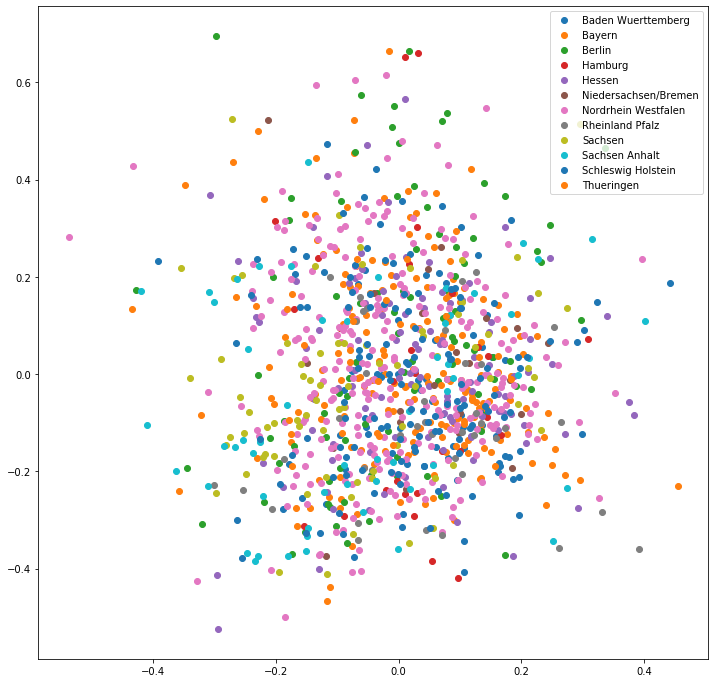

In [45]:
## Dimention recudtion using PCA

X = weight_pca[1:,1] # to remove the first category: the na class
Y = weight_pca[1:,0]
store_state_color_df = pd.DataFrame({"X":X,
                                     "Y":Y,
                                     "statename": store_2statenames})

plt.figure(figsize=(12,12))
groups = store_state_color_df.groupby("statename")
for name, group in groups:
    plt.plot(group["X"], group["Y"], marker="o", linestyle="", label=name)
plt.legend()
plt.show()


In [68]:
# data reduction via t-SNE algorithm
tsne = manifold.TSNE(init='pca', random_state=0, method='exact', perplexity=5, learning_rate=100, verbose=2, early_exaggeration=1)
t_matrix = tsne.fit_transform(weight_matrix_store)


[t-SNE] Computing pairwise distances...
[t-SNE] Computed conditional probabilities for sample 1000 / 1116
[t-SNE] Computed conditional probabilities for sample 1116 / 1116
[t-SNE] Mean sigma: 0.073601
[t-SNE] Iteration 50: error = 2.4050751, gradient norm = 0.0042778 (50 iterations in 2.553s)
[t-SNE] Iteration 100: error = 2.0195678, gradient norm = 0.0023634 (50 iterations in 2.568s)
[t-SNE] Iteration 150: error = 1.8550226, gradient norm = 0.0016023 (50 iterations in 2.521s)
[t-SNE] Iteration 200: error = 1.7577801, gradient norm = 0.0012167 (50 iterations in 2.566s)
[t-SNE] Iteration 250: error = 1.6921197, gradient norm = 0.0009055 (50 iterations in 2.559s)
[t-SNE] KL divergence after 250 iterations with early exaggeration: 1.692120
[t-SNE] Iteration 300: error = 1.6492261, gradient norm = 0.0006199 (50 iterations in 2.530s)
[t-SNE] Iteration 350: error = 1.5820118, gradient norm = 0.0004701 (50 iterations in 2.537s)
[t-SNE] Iteration 400: error = 1.5324210, gradient norm = 0.00036

In [69]:
t_matrix

array([[-19.138529 ,  -6.891047 ],
       [ -9.382007 , -38.269444 ],
       [-31.335117 ,  16.397568 ],
       ...,
       [ -6.4089365, -20.16972  ],
       [100.405205 , -25.988102 ],
       [-21.250744 , -49.737694 ]], dtype=float32)

In [105]:
# Data reduction using t-SNE

X = t_matrix[1:, 0] # ommit the first category: NA class
Y = t_matrix[1:, 1]

# make a dataframe so that we could use ggplot for the visualization
store_state_color_df = pd.DataFrame({"X":X,
                                     "Y":Y,
                                     "statename": store_2statenames,
                                   "store_idx": list(learn.dls.train_ds.classes["Store"][1:])})

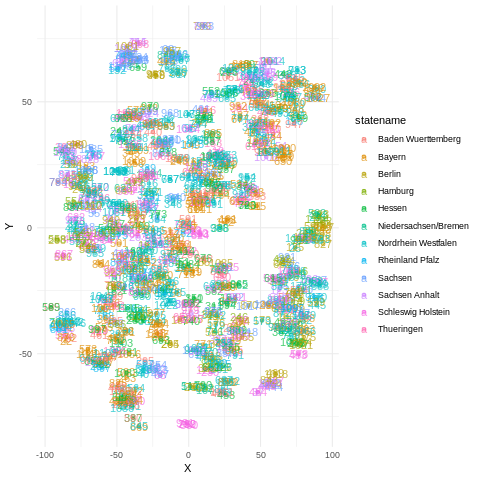

In [110]:
%%R 
# load the ggplot2 library
library(ggplot2)

p = ggplot(
store_state_color_df, aes(x= X, y= Y, color = statename))+
    geom_point(alpha = 0.5)+
    geom_text(aes(label = store_idx), alpha = 0.7)+
    theme_minimal()
p

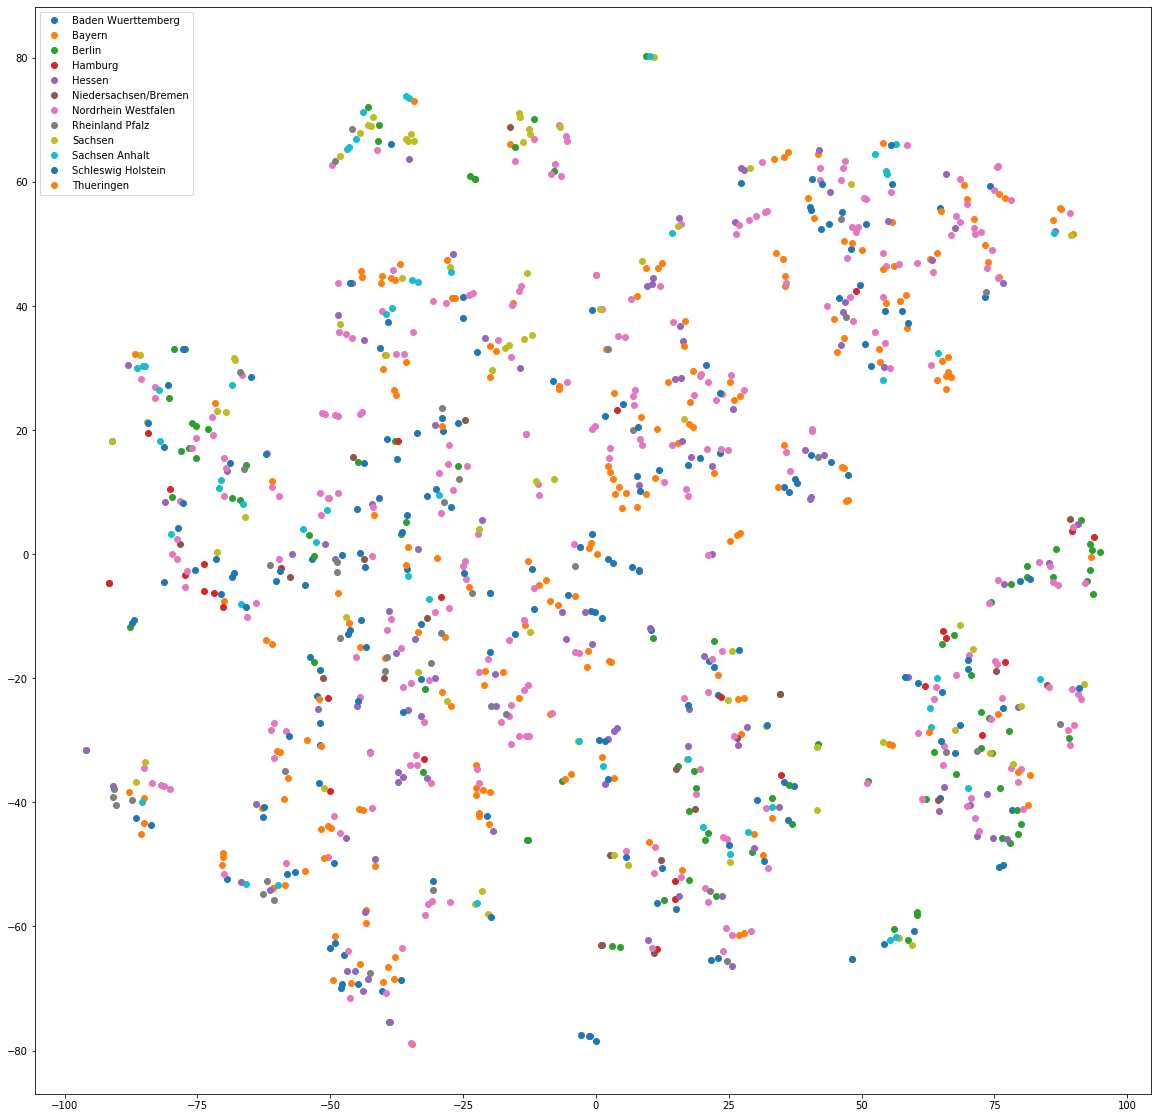

In [81]:

groups = store_state_color_df.groupby("statename")

plt.figure(figsize=(20,20))


for name, group in groups:
    plt.plot(group["X"], group["Y"], marker="o", linestyle="", label=name)


plt.legend()
plt.show()



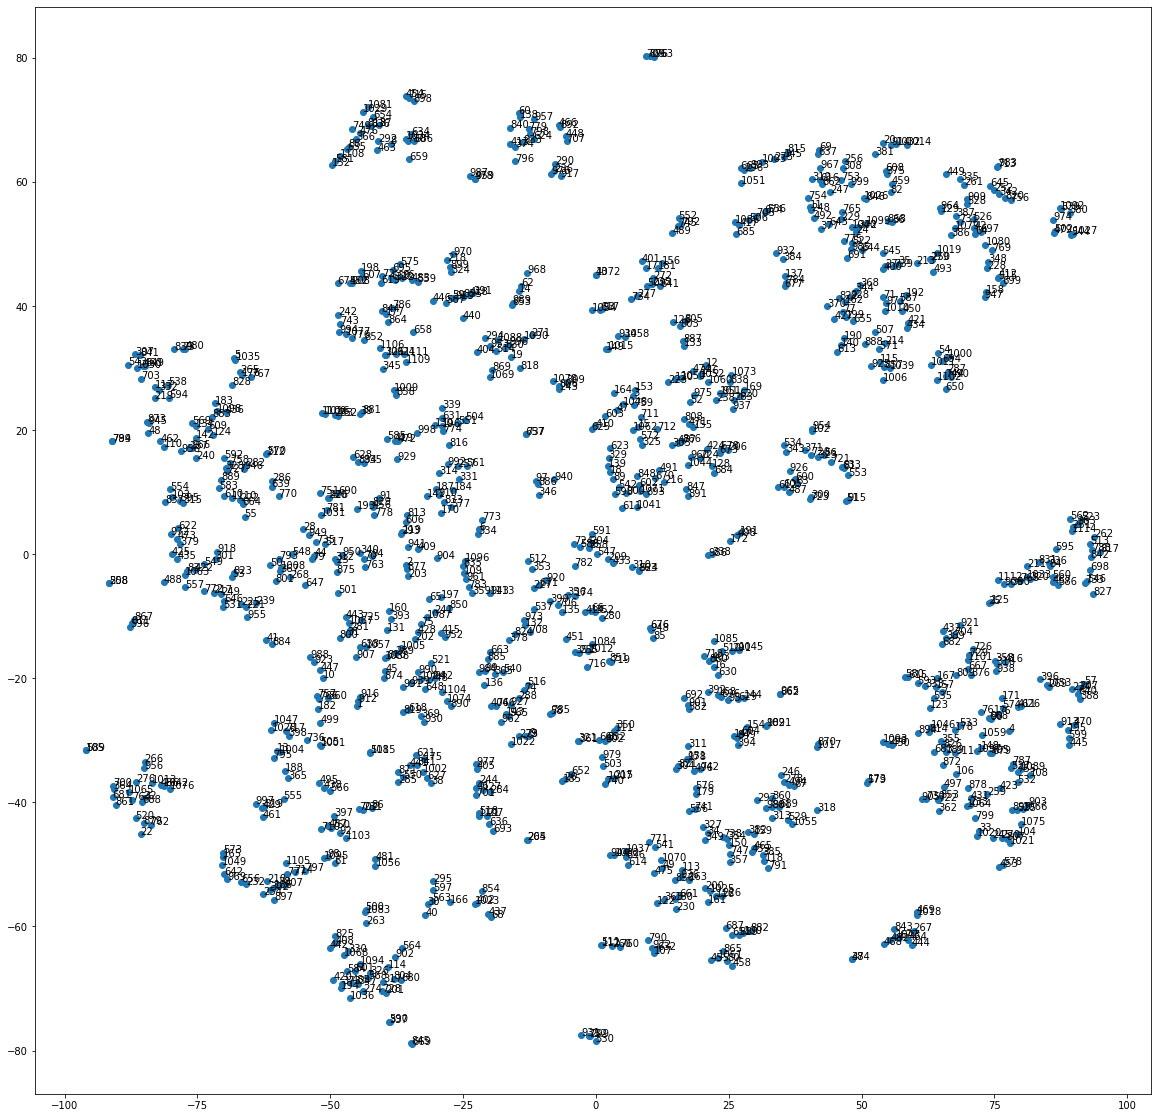

In [77]:
plt.figure(figsize=(20,20))

plt.scatter(X, Y)

for x, y, txt in zip(X, Y, list(learn.dls.train_ds.classes["Store"])[1:]):
    plt.annotate(str(txt), (x,y))


plt.show()

In [84]:
store_state_color_df

,X,Y,statename
0,-45.034454,-24.552702,Hessen
1,-35.684532,-1.676102,Thueringen
2,7.024644,25.504971,Nordrhein Westfalen
3,77.710770,-28.505589,Berlin
4,-68.089760,31.685863,Sachsen
...,...,...,...
1110,-36.095757,32.213425,Nordrhein Westfalen
1111,75.725319,-4.140266,Nordrhein Westfalen
1112,-19.894022,-6.311983,Schleswig Holstein
1113,89.561646,3.663664,Hamburg


## 3D T-sne visulization of stores

In [70]:
tsne = manifold.TSNE(n_components=3 ,init='pca', random_state=0, method='exact', perplexity=5, learning_rate=100, verbose=2, early_exaggeration=1)
t_matrix = tsne.fit_transform(weight_matrix_store)


[t-SNE] Computing pairwise distances...
[t-SNE] Computed conditional probabilities for sample 1000 / 1116
[t-SNE] Computed conditional probabilities for sample 1116 / 1116
[t-SNE] Mean sigma: 0.073601
[t-SNE] Iteration 50: error = 2.0031426, gradient norm = 0.0021114 (50 iterations in 4.669s)
[t-SNE] Iteration 100: error = 1.6301577, gradient norm = 0.0007029 (50 iterations in 4.653s)
[t-SNE] Iteration 150: error = 1.4929931, gradient norm = 0.0003984 (50 iterations in 4.648s)
[t-SNE] Iteration 200: error = 1.4221860, gradient norm = 0.0002647 (50 iterations in 4.650s)
[t-SNE] Iteration 250: error = 1.3788715, gradient norm = 0.0001906 (50 iterations in 4.653s)
[t-SNE] KL divergence after 250 iterations with early exaggeration: 1.378871
[t-SNE] Iteration 300: error = 1.3621051, gradient norm = 0.0001251 (50 iterations in 4.647s)
[t-SNE] Iteration 350: error = 1.3286043, gradient norm = 0.0000926 (50 iterations in 4.632s)
[t-SNE] Iteration 400: error = 1.3005074, gradient norm = 0.00006

In [74]:
# Data reduction using t-SNE

X = t_matrix[1:, 0] # ommit the first category: NA class
Y = t_matrix[1:, 1]
Z = t_matrix[1:, 2]

store_state_color_df_3d = pd.DataFrame({"X":X,
                                     "Y":Y,
                                     "Z": Z,
                                     "statename": store_2statenames,
                                    "store_idx": list(learn.dls.train_ds.classes["Store"][1:])})


In [84]:
store_state_color_df_3d.head()

,X,Y,Z,statename,store_idx
0,-10.657735,-10.861790,12.033182,Hessen,1
1,-4.813772,8.815219,-0.010091,Thueringen,2
2,2.057903,11.323193,0.148164,Nordrhein Westfalen,3
3,13.423047,-0.130926,-18.406282,Berlin,4
4,-19.847792,5.057338,-6.864569,Sachsen,5


In [85]:
state_2num_dict = { j:i for i, j in state_dict.items()}

In [87]:
store_state_color_df_3d["state_num"] = store_state_color_df_3d["statename"].map(state_2num_dict)

In [76]:
from mpl_toolkits.mplot3d import Axes3D

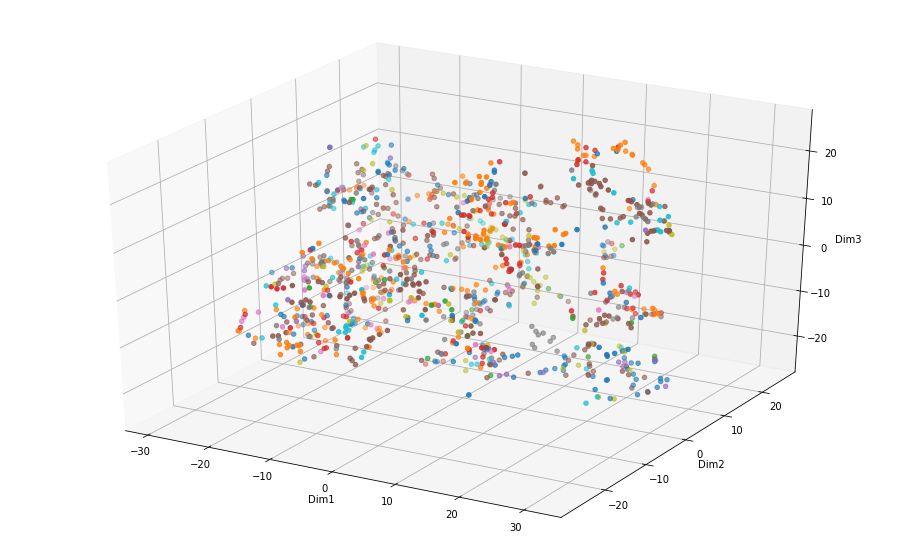

In [90]:
ax = plt.figure(figsize=(16,10)).gca(projection='3d')
ax.scatter(
    xs=store_state_color_df_3d["X"], 
    ys=store_state_color_df_3d["Y"], 
    zs=store_state_color_df_3d["Z"], 
    c= store_state_color_df_3d["state_num"], 
    cmap='tab10'
)
ax.set_xlabel('Dim1')
ax.set_ylabel('Dim2')
ax.set_zlabel('Dim3')
plt.show()

## Find similar stores through KNN from embeddings

In [334]:
# Some functions to get KNN 
# Borrowed code from https://github.com/fastai/fastai/blob/master/courses/dl2/devise.ipynb
import nmslib

def create_index(a):
    index = nmslib.init(space='angulardist')
    index.addDataPointBatch(a)
    index.createIndex()
    return index

def get_knns(index, vecs):
     return zip(*index.knnQueryBatch(vecs, k=10, num_threads=4))

def get_knn(index, vec): return index.knnQuery(vec, k=10)

In [335]:
knn_indices = create_index(weight_matrix_store)

In [ ]:
store_963 = weight_matrix_store[964]

close_to_store_963, _ = get_knn(knn_indices, store_963)
close_to_store_963

In [132]:
# Test the store distance
weight_matrix_state = learn.model.embeds[13].weight.cpu().detach().numpy()
knn_indices = create_index(weight_matrix_state) 
Berlin_idx = weight_matrix_state[1]
idx, distance = get_knn(knn_indices, Berlin_idx)
close_to_Berlin = [states_names[i] for i in idx]

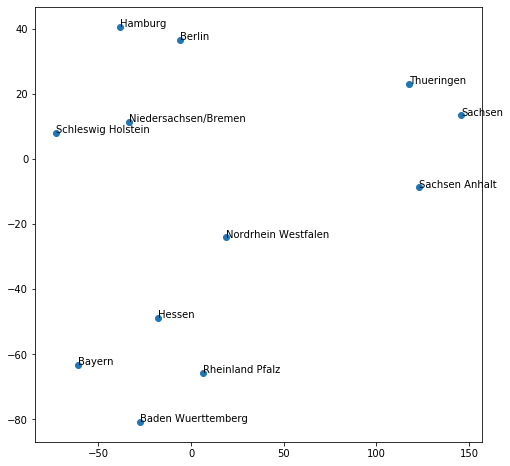

In [138]:
tsne = manifold.TSNE(init='pca', random_state=0, method='exact', perplexity=5, learning_rate=100)
Y = tsne.fit_transform(learn.model.embeds[13].weight.cpu().detach().numpy()[1:])
plt.figure(figsize=(8,8))
plt.scatter(Y[:, 0], -Y[:, 1])
for i, txt in enumerate(states_names[1:]):
    plt.annotate(txt, (Y[i, 0], -Y[i, 1]))

In [134]:
close_to_Berlin

['Berlin',
 'Hamburg',
 'Niedersachsen/Bremen',
 'Bayern',
 'Hessen',
 '#NA#',
 'Sachsen',
 'Schleswig Holstein',
 'Baden Wuerttemberg',
 'Thueringen']

In [336]:
def gen_similar_disimilar_store(knn_order):
    close_random_stores = list(knn_order[:3]) + list(np.random.choice(range(1115), 3))
    print(close_random_stores)
    df_inner = train_df[train_df.Store.isin(close_random_stores)]
    start_date = "07-31-2014" ; end_date = "07-31-2015"
    mask = (df_inner['Date'] > start_date) & (df_inner['Date'] <= end_date)
    df_inner = df_inner.loc[mask]
    return df_inner, close_random_stores
    



In [374]:
store_selected = weight_matrix_store[200]

close_to_store_selected, _ = get_knn(knn_indices, store_selected)


In [376]:
df_selected, store_selected = gen_similar_disimilar_store(close_to_store_selected)
store_selected   # The last three are not random drawn, not similar stores

[200, 1025, 760, 895, 723, 648]


[200, 1025, 760, 895, 723, 648]

In [378]:
%%R -i store_selected
# load the ggplot2 library
library(ggplot2)
df_selected$Date = as.Date(df_selected$Date , format = "%m/%d/%y")


df_selected$Store = as.factor(df_selected$Store)
# You need the following tweak to make sure the levels are correct with colors in ggplot
df_selected$Store <- factor(df_selected$Store, levels = unlist(store_selected))
df_selected$Sales = exp(df_selected$Sales)


# factor(c("small", "large", "large", "small", "medium"),
#                 levels = c("small", "medium", "large"))
# df_125$Store = relevel(df_125$Store, c(125, 320, 1033, 1016, 1020, 416))

p = ggplot(df_selected, aes(x= Date, y= Sales, color = Store))+
    geom_line()+
    theme_minimal()+
    scale_x_date(date_labels = "%b/%Y")+
    scale_color_manual(values = c("#CC79A7", "#E7B800", "#FC4E07",
                                 "#999999","#999999","#999999"))




ggsave("same_store_plot.png", width = 20, height = 8)

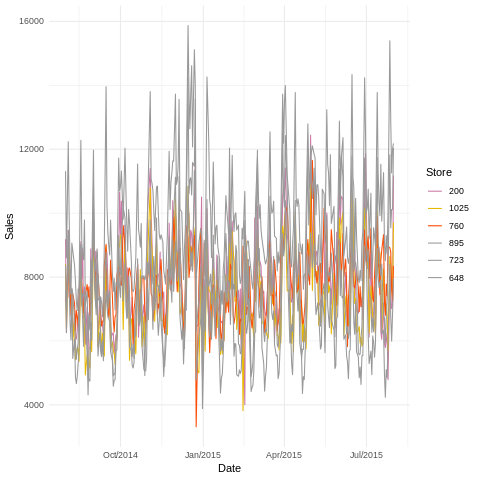

In [379]:
%%R
p

In [0]:
train_df_copy = learn.dls.train_ds

In [82]:
state_dict = {i:j for i, j in zip(range(13), states_names)}
state_dict

{0: '#NA#',
 1: 'Berlin',
 2: 'Baden Wuerttemberg',
 3: 'Bayern',
 4: 'Niedersachsen/Bremen',
 5: 'Hessen',
 6: 'Hamburg',
 7: 'Nordrhein Westfalen',
 8: 'Rheinland Pfalz',
 9: 'Schleswig Holstein',
 10: 'Sachsen',
 11: 'Sachsen Anhalt',
 12: 'Thueringen'}

In [94]:
train_df_copy["State"]

41395      5
41396      5
41397     12
41398      7
41399      1
          ..
844333     1
844334     7
844335     7
844336     2
844337     8
Name: State, Length: 802943, dtype: int8

In [0]:
train_df_copy['state_name'] = train_df_copy["State"].map(state_dict)

In [97]:
train_df_copy['state_name']

41395                  Hessen
41396                  Hessen
41397              Thueringen
41398     Nordrhein Westfalen
41399                  Berlin
                 ...         
844333                 Berlin
844334    Nordrhein Westfalen
844335    Nordrhein Westfalen
844336     Baden Wuerttemberg
844337        Rheinland Pfalz
Name: state_name, Length: 802943, dtype: object

In [67]:
X = weight_pca[:,0]
Y = weight_pca[:,1]
plt.figure(figsize=(12,12))
plt.scatter(X, Y)
for i, x, y in zip(learn.dls.train_ds.classes["Store"], X, Y):
    plt.text(x,y,i, color=np.random.rand(3)*0.7, fontsize=13)
plt.show()

(#13) ['#na#','BE','BW','BY','HB,NI','HE','HH','NW','RP','SH'...]

In [72]:
# Add the state full name below corresponding to the abbreviations
print(learn.dls.train_ds.classes["State"])

states_names = ["#NA#", 'Berlin', 'Baden Wuerttemberg', 'Bayern', 'Niedersachsen/Bremen', 
                'Hessen', 'Hamburg', 'Nordrhein Westfalen', 'Rheinland Pfalz',
                'Schleswig Holstein', 'Sachsen', 'Sachsen Anhalt', 'Thueringen']

(#13) ['#na#','BE','BW','BY','HB,NI','HE','HH','NW','RP','SH'...]


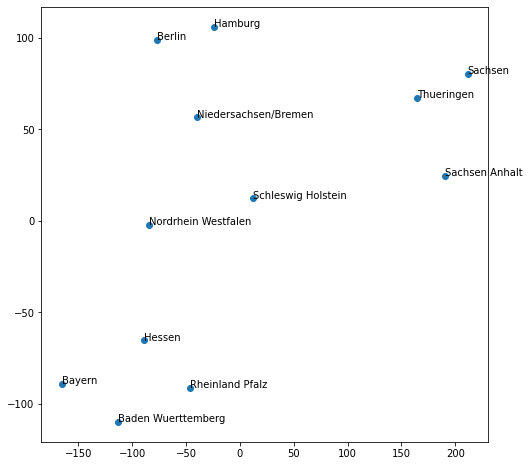

In [124]:
tsne = manifold.TSNE(init='pca', random_state=0, method='exact', perplexity=5, learning_rate=100)
Y = tsne.fit_transform(learn.model.embeds[13].weight.cpu().detach().numpy()[1:])
plt.figure(figsize=(8,8))
plt.scatter(-Y[:, 0], Y[:, 1])
for i, txt in enumerate(states_names[1:]):
    plt.annotate(txt, (-Y[i, 0], Y[i, 1]))

#plt.show()
plt.savefig('state_embedding.pdf')



In [0]:
learn.dls.train_ds.classes

{'Assortment': (#4) ['#na#','a','b','c'],
 'CloudCover_na': (#3) ['#na#',False,True],
 'CompetitionDistance_na': (#3) ['#na#',False,True],
 'CompetitionMonthsOpen': (#26) ['#na#',0,1,2,3,4,5,6,7,8...],
 'CompetitionOpenSinceYear': (#24) ['#na#',1900,1961,1990,1994,1995,1998,1999,2000,2001...],
 'Day': (#32) ['#na#',1,2,3,4,5,6,7,8,9...],
 'DayOfWeek': (#8) ['#na#',1,2,3,4,5,6,7],
 'Events': (#22) ['#na#','Fog','Fog-Rain','Fog-Rain-Hail','Fog-Rain-Hail-Thunderstorm','Fog-Rain-Snow','Fog-Rain-Snow-Hail','Fog-Rain-Thunderstorm','Fog-Snow','Fog-Snow-Hail'...],
 'Month': (#13) ['#na#',1,2,3,4,5,6,7,8,9...],
 'Promo': (#3) ['#na#',0,1],
 'Promo2SinceYear': (#9) ['#na#',1900,2009,2010,2011,2012,2013,2014,2015],
 'Promo2Weeks': (#27) ['#na#',0,1,2,3,4,5,6,7,8...],
 'PromoInterval': (#4) ['#na#','Feb,May,Aug,Nov','Jan,Apr,Jul,Oct','Mar,Jun,Sept,Dec'],
 'Promo_bw': (#7) ['#na#',0.0,1.0,2.0,3.0,4.0,5.0],
 'Promo_fw': (#7) ['#na#',0.0,1.0,2.0,3.0,4.0,5.0],
 'SchoolHoliday': (#3) ['#na#',0,1],
 'Sc

In [0]:
learn.model.embeds

ModuleList(
  (0): Embedding(1116, 81)
  (1): Embedding(8, 5)
  (2): Embedding(4, 3)
  (3): Embedding(13, 7)
  (4): Embedding(32, 11)
  (5): Embedding(3, 3)
  (6): Embedding(26, 10)
  (7): Embedding(27, 10)
  (8): Embedding(5, 4)
  (9): Embedding(4, 3)
  (10): Embedding(4, 3)
  (11): Embedding(24, 9)
  (12): Embedding(9, 5)
  (13): Embedding(13, 7)
  (14): Embedding(53, 15)
  (15): Embedding(22, 9)
  (16): Embedding(7, 5)
  (17): Embedding(7, 5)
  (18): Embedding(4, 3)
  (19): Embedding(4, 3)
  (20): Embedding(9, 5)
  (21): Embedding(9, 5)
  (22): Embedding(3, 3)
  (23): Embedding(3, 3)
  (24): Embedding(3, 3)
  (25): Embedding(3, 3)
)